In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from operator import index
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from fastai.tabular.all import df_shrink
from google.colab import data_table
from google.colab import files
from sklearn import metrics
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import keras
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

testing = '/content/drive/MyDrive/Senior Database Files/KDDTest+.csv'
training = '/content/drive/MyDrive/Senior Database Files/KDDTrain+.csv'

train = pd.read_csv(training, encoding='utf-8')
test = pd.read_csv(testing, encoding='utf-8')

train = df_shrink(train, skip=[], obj2cat=True, int2uint=True)
test = df_shrink(test, skip=[], obj2cat=True, int2uint=True)

feature_type_map = {f: (train.dtypes.loc[f], test.dtypes.loc[f]) for f in train.columns}

len(train['class'].cat.categories), len(test['class'].cat.categories)

len(train.service.cat.categories), len(test.service.cat.categories)

def train_test_category_union(feature):
  tcl = len(train[feature].cat.categories)
  tcll = len(test[feature].cat.categories)
  feature_cat_union = train[feature].cat.categories.union(test[feature].cat.categories)
  train[feature] = train[feature].cat.set_categories(feature_cat_union)
  test[feature] = test[feature].cat.set_categories(feature_cat_union)

cat = list(train.select_dtypes(include='category').columns.values)

for f in cat:
  train_test_category_union(f)

le = LabelEncoder()
train['classification'] = le.fit_transform(train['class'])
test['classification'] = le.fit_transform(test['class'])
train.drop('class', axis=1, inplace=True)
test.drop('class', axis=1, inplace=True)
train['protocol_type'] = le.fit_transform(train['protocol_type'])
test['protocol_type'] = le.fit_transform(test['protocol_type'])
train['service'] = le.fit_transform(train['service'])
test['service'] = le.fit_transform(test['service'])
train['flag'] = le.fit_transform(train['flag'])
test['flag'] = le.fit_transform(test['flag'])
train['land'] = le.fit_transform(train['land'])
test['land'] = le.fit_transform(test['land'])
train['logged_in'] = le.fit_transform(train['logged_in'])
test['logged_in'] = le.fit_transform(test['logged_in'])
train['is_host_login'] = le.fit_transform(train['is_host_login'])
test['is_host_login'] = le.fit_transform(test['is_host_login'])
train['is_guest_login'] = le.fit_transform(train['is_guest_login'])
test['is_guest_login'] = le.fit_transform(test['is_guest_login'])

class_data_train = train['classification']

train_index = train.columns
mutual_info = mutual_info_classif(train, class_data_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_index
mutual_info.sort_values(ascending=False)
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(train, class_data_train)
new_col = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'classification']
train = train[new_col]
test = test[new_col]

#one hot encoding on all nominal categories except class
test = pd.get_dummies(test, columns=['protocol_type', 'service', 'flag', 'logged_in'])
train = pd.get_dummies(train, columns=['protocol_type', 'service', 'flag', 'logged_in'])

#robust scaling for normalization step
target_train = train['classification'].copy()
target_test = test['classification'].copy()
robust_scaler1 = RobustScaler()
robust_scaler2 = RobustScaler()
train.drop('classification', axis=1, inplace=True)
test.drop('classification', axis=1, inplace=True)
data1 = test.values[:, :]
data2 = train.values[:, :]
data1 = robust_scaler1.fit_transform(data1)
data2 = robust_scaler2.fit_transform(data2)
#converting array back to dataframe
test = pd.DataFrame(data1)
train = pd.DataFrame(data2)
#Preprocessing ends here
#print(target_test)


In [ ]:
train_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dataset = pd.get_dummies(dataset)
train = dataset[:train_num]
test = dataset[train_num:]
train = train.fillna(0)
test = test.fillna(0)
x_train = train[target_train == 0]
x_test = test
x_train = x_train.values
x_test = x_test.values

minScaler = MinMaxScaler()
x_train_scaled = minScaler.fit_transform(x_train)
x_test_scaled = minScaler.fit_transform(x_test)
y_test = pd.DataFrame.copy(target_test)
x_train_df = pd.DataFrame(x_train_scaled)
x_test_df = pd.DataFrame(x_test_scaled)
#pca = PCA(n_components = 0.95)
#pca.fit(x_train_scaled)
#x_train_pca = pca.transform(x_train_scaled)


In [ ]:
acc = {0}
seed = {0}
num_seed = 1

In [ ]:
#Building the autoencoder
num_seed = 471
num_epochs = 15
batch_num = 1019
for i in range(500):
  print("num_seed:", num_seed)
  tf.keras.utils.set_random_seed(num_seed)
  auto_model = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train_df.shape[1],)), tf.keras.layers.Dense(64, activation='relu'), tf.keras.layers.Dense(32, activation='relu'), tf.keras.layers.Dense(64, activation='relu'), tf.keras.layers.Dense(128, activation='relu'), tf.keras.layers.Dense(x_train_df.shape[1], activation='sigmoid')])
  auto_model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.Accuracy])
  #Training model
  #history = auto_model.fit(x_train_scaled, x_train_scaled, epochs=175, batch_size=1000, validation_data=(x_train_scaled, x_train_scaled))
  history = auto_model.fit(x_train_df, x_train_df, epochs=num_epochs, shuffle=True, batch_size=batch_num, validation_data=(x_train_df, x_train_df))

  tf.keras.utils.set_random_seed(num_seed)
  predictions  = auto_model.predict(x_test_scaled)
  recon_error = dict()
  for i in range(len(x_test_scaled)):
    recon_error[i] = np.mean(np.power(x_test_scaled[i] - predictions[i], 2))
  #get mean squared error
  mean_squared_error = metrics.mean_squared_error(predictions, x_test_scaled)
  #print(mean_squared_error)
  df_error = pd.DataFrame({'reconstruction_error': recon_error, 'Label': target_test}, index=test.index)

  outliers = df_error.index[df_error.reconstruction_error > mean_squared_error].tolist()
  #reconstructionerrors = df_error.reconstruction_error.tolist()
  #print(len(outliers))
  #print(outliers)

  num = 0
  for i in range(len(y_test)):
    y_test[i] = 1

  for i in range(len(outliers)):
    y_test[outliers[i]] = 0

  accuracy = accuracy_score(target_test, y_test)
  print("accuracy:", accuracy)
  #precision = precision_score(target_test, y_test)
  #print(precision)
  #recall = recall_score(target_test, y_test)
  #print(recall)
  if accuracy > 0.67:
    acc.add(accuracy)
  num_seed = num_seed + 1
  #num_epochs = num_epochs + 1
  #batch_num = batch_num + 1



num_seed: 471


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0000e+00 - loss: 0.1716 - val_accuracy: 0.0000e+00 - val_loss: 0.0241
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 1.1921e-08 - loss: 0.0204 - val_accuracy: 2.6375e-06 - val_loss: 0.0126
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 8.6958e-04 - loss: 0.0115 - val_accuracy: 0.0037 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0046 - loss: 0.0088 - val_accuracy: 0.0061 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.0066 - loss: 0.0080 - val_accuracy: 0.0094 - val_loss: 0.0079
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0098 - loss: 0.0079 - val_accuracy: 0.0104 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0105 - loss: 0.0079 - val_accuracy: 0.0111 - val_loss: 0.0078
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0113 - loss: 0.0079 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1693 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0214 - val_accuracy: 0.0000e+00 - val_loss: 0.0153
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0143 - val_accuracy: 0.0000e+00 - val_loss: 0.0110
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 4.1218e-04 - loss: 0.0105 - val_accuracy: 0.0051 - val_loss: 0.0095
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0059 - loss: 0.0094 - val_accuracy: 0.0075 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0082 - loss: 0.0092 - val_accuracy: 0.0110 - val_loss: 0.0091
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0123 - loss: 0.0091 - val_accuracy: 0.0147 - val_loss: 0.0091
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0148 - loss: 0.009

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1574 - val_accuracy: 0.0000e+00 - val_loss: 0.0218
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.1393e-06 - loss: 0.0181 - val_accuracy: 6.7187e-04 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0025 - loss: 0.0117 - val_accuracy: 0.0039 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0047 - loss: 0.0090 - val_accuracy: 0.0081 - val_loss: 0.0085
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0089 - loss: 0.0084 - val_accuracy: 0.0125 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0128 - loss: 0.0082 - val_accuracy: 0.0137 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0139 - loss: 0.0082 - val_accuracy: 0.0145 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0146 - loss: 0.0081 - val_accu

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0000e+00 - loss: 0.1654 - val_accuracy: 0.0000e+00 - val_loss: 0.0241
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0207 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0121 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.2031e-08 - loss: 0.0088 - val_accuracy: 1.0550e-06 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.5667e-05 - loss: 0.0083 - val_accuracy: 3.6222e-04 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0010 - loss: 0.0081 - val_accuracy: 0.0014 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0015 - loss: 0.0080 - val_accuracy: 0.0019 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0019 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1676 - val_accuracy: 0.0000e+00 - val_loss: 0.0237
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0196 - val_accuracy: 0.0000e+00 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0119 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0089 - val_accuracy: 0.0000e+00 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0084 - val_accuracy: 0.0000e+00 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.0315e-05 - loss: 0.0081 - val_accuracy: 7.1829e-04 - val_loss: 0.0081
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 6.9670e-04 - loss: 0.0081 - val_accuracy: 7.1882e-04 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - ac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1564 - val_accuracy: 0.0000e+00 - val_loss: 0.0231
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0190 - val_accuracy: 0.0000e+00 - val_loss: 0.0121
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0111 - val_accuracy: 0.0000e+00 - val_loss: 0.0089
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0086 - val_accuracy: 0.0000e+00 - val_loss: 0.0079
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0079 - val_accuracy: 0.0000e+00 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.1985e-04 - loss: 0.0078 - val_accuracy: 7.1935e-04 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.1533e-04 - loss: 0.0077 - val_accuracy: 7.5328e-04 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - ac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0000e+00 - loss: 0.1759 - val_accuracy: 0.0000e+00 - val_loss: 0.0255
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 2.7013e-06 - loss: 0.0222 - val_accuracy: 0.0010 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0040 - loss: 0.0120 - val_accuracy: 0.0065 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0068 - loss: 0.0085 - val_accuracy: 0.0087 - val_loss: 0.0074
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0103 - loss: 0.0073 - val_accuracy: 0.0142 - val_loss: 0.0072
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0152 - loss: 0.0071 - val_accuracy: 0.0165 - val_loss: 0.0071
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0167 - loss: 0.0070 - val_accuracy: 0.0171 - val_loss: 0.0070
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0171 - loss: 0.0070 - val_accuracy

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1497 - val_accuracy: 0.0000e+00 - val_loss: 0.0224
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0193 - val_accuracy: 0.0000e+00 - val_loss: 0.0146
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0133 - val_accuracy: 0.0000e+00 - val_loss: 0.0102
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.7297e-04 - loss: 0.0097 - val_accuracy: 0.0039 - val_loss: 0.0081
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0056 - loss: 0.0079 - val_accuracy: 0.0068 - val_loss: 0.0074
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0068 - loss: 0.0068 - val_accuracy: 0.0070 - val_loss: 0.0059
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0070 - loss: 0.0059 - val_accuracy: 0.0071 - val_loss: 0.0058
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0071 - loss: 0.005

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1602 - val_accuracy: 0.0000e+00 - val_loss: 0.0231
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0204 - val_accuracy: 0.0000e+00 - val_loss: 0.0166
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0147 - val_accuracy: 0.0000e+00 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0107 - val_accuracy: 0.0000e+00 - val_loss: 0.0104
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0103 - val_accuracy: 1.7584e-07 - val_loss: 0.0102
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 9.0773e-05 - loss: 0.0101 - val_accuracy: 7.9970e-04 - val_loss: 0.0100
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 9.4331e-04 - loss: 0.0100 - val_accuracy: 0.0014 - val_loss: 0.0100
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accura

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1578 - val_accuracy: 0.0000e+00 - val_loss: 0.0234
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0199 - val_accuracy: 0.0000e+00 - val_loss: 0.0143
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0124 - val_accuracy: 0.0000e+00 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0090 - val_accuracy: 0.0000e+00 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 3.8721e-08 - loss: 0.0081 - val_accuracy: 4.7476e-06 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.5443e-05 - loss: 0.0077 - val_accuracy: 7.9566e-04 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0012 - loss: 0.0077 - val_accuracy: 0.0022 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1743 - val_accuracy: 0.0000e+00 - val_loss: 0.0221
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0179 - val_accuracy: 0.0000e+00 - val_loss: 0.0113
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 3.2953e-06 - loss: 0.0106 - val_accuracy: 2.7272e-04 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 4.0057e-04 - loss: 0.0095 - val_accuracy: 0.0014 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0020 - loss: 0.0092 - val_accuracy: 0.0049 - val_loss: 0.0091
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0051 - loss: 0.0091 - val_accuracy: 0.0057 - val_loss: 0.0091
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0058 - loss: 0.0090 - val_accuracy: 0.0065 - val_loss: 0.0091
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.009

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1640 - val_accuracy: 0.0000e+00 - val_loss: 0.0217
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0182 - val_accuracy: 0.0000e+00 - val_loss: 0.0114
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0108 - val_accuracy: 0.0000e+00 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0096 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 3.9744e-04 - loss: 0.0089 - val_accuracy: 0.0030 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0032 - loss: 0.0084 - val_accuracy: 0.0035 - val_loss: 0.0083
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0039 - loss: 0.0083 - val_accuracy: 0.0059 - val_loss: 0.0082
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0065 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0000e+00 - loss: 0.1635 - val_accuracy: 0.0000e+00 - val_loss: 0.0253
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0222 - val_accuracy: 0.0000e+00 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0123 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0091 - val_accuracy: 0.0000e+00 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0087 - val_accuracy: 0.0000e+00 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0085 - val_accuracy: 1.7584e-07 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 4.4169e-04 - loss: 0.0084 - val_accuracy: 0.0021 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accura

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1687 - val_accuracy: 0.0000e+00 - val_loss: 0.0196
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0180 - val_accuracy: 0.0000e+00 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0122 - val_accuracy: 0.0000e+00 - val_loss: 0.0110
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0109 - val_accuracy: 3.6926e-06 - val_loss: 0.0107
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 7.8556e-05 - loss: 0.0106 - val_accuracy: 0.0011 - val_loss: 0.0105
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0016 - loss: 0.0104 - val_accuracy: 0.0027 - val_loss: 0.0104
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0030 - loss: 0.0104 - val_accuracy: 0.0037 - val_loss: 0.0104
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0037 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1735 - val_accuracy: 0.0000e+00 - val_loss: 0.0181
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0162 - val_accuracy: 0.0000e+00 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.0264e-07 - loss: 0.0119 - val_accuracy: 4.6069e-05 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.1715e-04 - loss: 0.0102 - val_accuracy: 0.0042 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0049 - loss: 0.0098 - val_accuracy: 0.0064 - val_loss: 0.0097
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.0096 - val_accuracy: 0.0077 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0080 - loss: 0.0096 - val_accuracy: 0.0088 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0089 - loss: 0.009

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1732 - val_accuracy: 0.0000e+00 - val_loss: 0.0231
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0191 - val_accuracy: 0.0000e+00 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0113 - val_accuracy: 1.7584e-07 - val_loss: 0.0096
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.9032e-05 - loss: 0.0095 - val_accuracy: 5.4615e-04 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0016 - loss: 0.0086 - val_accuracy: 0.0052 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0062 - loss: 0.0081 - val_accuracy: 0.0100 - val_loss: 0.0081
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0107 - loss: 0.0081 - val_accuracy: 0.0123 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0123 - loss: 0.0081 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1585 - val_accuracy: 0.0000e+00 - val_loss: 0.0242
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 3.7759e-04 - loss: 0.0203 - val_accuracy: 0.0060 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.0114 - val_accuracy: 0.0083 - val_loss: 0.0089
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0084 - loss: 0.0087 - val_accuracy: 0.0085 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0086 - loss: 0.0083 - val_accuracy: 0.0089 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0098 - loss: 0.0080 - val_accuracy: 0.0118 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0125 - loss: 0.0080 - val_accuracy: 0.0142 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0145 - loss: 0.0080 - val_accuracy

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.0000e+00 - loss: 0.1631 - val_accuracy: 0.0000e+00 - val_loss: 0.0228
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0191 - val_accuracy: 0.0000e+00 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 4.5236e-05 - loss: 0.0109 - val_accuracy: 8.9342e-04 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0016 - loss: 0.0092 - val_accuracy: 0.0037 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0050 - loss: 0.0082 - val_accuracy: 0.0067 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0069 - loss: 0.0079 - val_accuracy: 0.0072 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0074 - loss: 0.0079 - val_accuracy: 0.0075 - val_loss: 0.0078
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0078 - loss: 0.0078 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1682 - val_accuracy: 0.0000e+00 - val_loss: 0.0257
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0242 - val_accuracy: 0.0000e+00 - val_loss: 0.0153
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0133 - val_accuracy: 0.0000e+00 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0093 - val_accuracy: 0.0000e+00 - val_loss: 0.0085
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0082 - val_accuracy: 0.0000e+00 - val_loss: 0.0074
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 4.3431e-06 - loss: 0.0073 - val_accuracy: 7.2444e-05 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 3.3554e-04 - loss: 0.0072 - val_accuracy: 0.0017 - val_loss: 0.0071
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0018 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1553 - val_accuracy: 0.0000e+00 - val_loss: 0.0230
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0196 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 4.9385e-07 - loss: 0.0117 - val_accuracy: 4.1322e-05 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 3.2925e-04 - loss: 0.0091 - val_accuracy: 0.0025 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0032 - loss: 0.0086 - val_accuracy: 0.0038 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0038 - loss: 0.0083 - val_accuracy: 0.0041 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0044 - loss: 0.0075 - val_accuracy: 0.0052 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0053 - loss: 0.007

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.0000e+00 - loss: 0.1765 - val_accuracy: 0.0000e+00 - val_loss: 0.0226
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0195 - val_accuracy: 0.0000e+00 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0139 - val_accuracy: 0.0000e+00 - val_loss: 0.0118
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0116 - val_accuracy: 0.0000e+00 - val_loss: 0.0113
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0111 - val_accuracy: 0.0000e+00 - val_loss: 0.0109
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0104 - val_accuracy: 0.0000e+00 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.0491e-04 - loss: 0.0096 - val_accuracy: 7.1864e-04 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.2

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1647 - val_accuracy: 0.0000e+00 - val_loss: 0.0215
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0191 - val_accuracy: 0.0000e+00 - val_loss: 0.0146
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 5.7068e-06 - loss: 0.0129 - val_accuracy: 6.6589e-04 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0020 - loss: 0.0102 - val_accuracy: 0.0056 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0060 - loss: 0.0092 - val_accuracy: 0.0064 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0066 - loss: 0.0088 - val_accuracy: 0.0079 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0082 - loss: 0.0087 - val_accuracy: 0.0105 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0105 - loss: 0.0087 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0000e+00 - loss: 0.1678 - val_accuracy: 0.0000e+00 - val_loss: 0.0262
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0234 - val_accuracy: 0.0000e+00 - val_loss: 0.0167
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.2345e-04 - loss: 0.0160 - val_accuracy: 0.0055 - val_loss: 0.0111
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0060 - loss: 0.0102 - val_accuracy: 0.0062 - val_loss: 0.0089
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0063 - loss: 0.0087 - val_accuracy: 0.0066 - val_loss: 0.0084
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0069 - loss: 0.0083 - val_accuracy: 0.0086 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0103 - loss: 0.0080 - val_accuracy: 0.0129 - val_loss: 0.0073
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0129 - loss: 0.0073 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 3.4219e-06 - loss: 0.1670 - val_accuracy: 0.0018 - val_loss: 0.0241
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0048 - loss: 0.0208 - val_accuracy: 0.0061 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0063 - loss: 0.0130 - val_accuracy: 0.0116 - val_loss: 0.0102
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0131 - loss: 0.0099 - val_accuracy: 0.0148 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0154 - loss: 0.0094 - val_accuracy: 0.0157 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0158 - loss: 0.0092 - val_accuracy: 0.0161 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0161 - loss: 0.0092 - val_accuracy: 0.0161 - val_loss: 0.0092
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0164 - loss: 0.0091 - val_accuracy: 0.0168

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1626 - val_accuracy: 0.0000e+00 - val_loss: 0.0231
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0199 - val_accuracy: 0.0000e+00 - val_loss: 0.0136
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0089 - val_accuracy: 0.0000e+00 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0790e-06 - loss: 0.0078 - val_accuracy: 1.6159e-04 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.2117e-04 - loss: 0.0076 - val_accuracy: 0.0044 - val_loss: 0.0073
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0044 - loss: 0.0073 - val_accuracy: 0.0046 - val_loss: 0.0073
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.00

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0000e+00 - loss: 0.1662 - val_accuracy: 0.0000e+00 - val_loss: 0.0200
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0175 - val_accuracy: 0.0000e+00 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0117 - val_accuracy: 0.0000e+00 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0095 - val_accuracy: 0.0000e+00 - val_loss: 0.0090
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0089 - val_accuracy: 0.0000e+00 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0087 - val_accuracy: 0.0000e+00 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.0480e-05 - loss: 0.0087 - val_accuracy: 6.2316e-04 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 8.3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1728 - val_accuracy: 0.0000e+00 - val_loss: 0.0253
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0222 - val_accuracy: 0.0000e+00 - val_loss: 0.0153
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0137 - val_accuracy: 0.0000e+00 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.8168e-04 - loss: 0.0095 - val_accuracy: 0.0048 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0060 - loss: 0.0081 - val_accuracy: 0.0090 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0099 - loss: 0.0079 - val_accuracy: 0.0123 - val_loss: 0.0078
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0125 - loss: 0.0077 - val_accuracy: 0.0131 - val_loss: 0.0078
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0132 - loss: 0.0077 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0000e+00 - loss: 0.1712 - val_accuracy: 0.0000e+00 - val_loss: 0.0214
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0187 - val_accuracy: 0.0000e+00 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.2822e-04 - loss: 0.0125 - val_accuracy: 0.0030 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0041 - loss: 0.0093 - val_accuracy: 0.0063 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0064 - loss: 0.0087 - val_accuracy: 0.0066 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0066 - loss: 0.0085 - val_accuracy: 0.0067 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0067 - loss: 0.0085 - val_accuracy: 0.0068 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0070 - loss: 0.0085 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1731 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.6680e-07 - loss: 0.0217 - val_accuracy: 1.1799e-04 - val_loss: 0.0159
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.4338e-04 - loss: 0.0142 - val_accuracy: 0.0060 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0060 - loss: 0.0097 - val_accuracy: 0.0061 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0069 - loss: 0.0086 - val_accuracy: 0.0094 - val_loss: 0.0079
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0103 - loss: 0.0078 - val_accuracy: 0.0126 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0127 - loss: 0.0077 - val_accuracy: 0.0136 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0138 - loss: 0.0074 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1706 - val_accuracy: 0.0000e+00 - val_loss: 0.0205
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0182 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0128 - val_accuracy: 0.0000e+00 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.3452e-06 - loss: 0.0107 - val_accuracy: 9.7941e-05 - val_loss: 0.0103
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 8.3277e-04 - loss: 0.0103 - val_accuracy: 0.0035 - val_loss: 0.0100
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0037 - loss: 0.0100 - val_accuracy: 0.0046 - val_loss: 0.0100
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0046 - loss: 0.0100 - val_accuracy: 0.0047 - val_loss: 0.0100
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0047 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1649 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 8.1523e-05 - loss: 0.0203 - val_accuracy: 0.0048 - val_loss: 0.0126
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0056 - loss: 0.0112 - val_accuracy: 0.0065 - val_loss: 0.0090
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0070 - loss: 0.0084 - val_accuracy: 0.0083 - val_loss: 0.0073
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0100 - loss: 0.0071 - val_accuracy: 0.0140 - val_loss: 0.0069
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0145 - loss: 0.0069 - val_accuracy: 0.0157 - val_loss: 0.0069
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0162 - loss: 0.0068 - val_accuracy: 0.0167 - val_loss: 0.0068
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0167 - loss: 0.0068 - val_accuracy: 0.0168 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1623 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0219 - val_accuracy: 0.0000e+00 - val_loss: 0.0154
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0139 - val_accuracy: 0.0000e+00 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0022 - loss: 0.0101 - val_accuracy: 0.0086 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0102 - loss: 0.0093 - val_accuracy: 0.0127 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0128 - loss: 0.0092 - val_accuracy: 0.0132 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0133 - loss: 0.0091 - val_accuracy: 0.0147 - val_loss: 0.0092
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0148 - loss: 0.0091 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.0000e+00 - loss: 0.1630 - val_accuracy: 0.0000e+00 - val_loss: 0.0181
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0167 - val_accuracy: 0.0000e+00 - val_loss: 0.0119
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0111 - val_accuracy: 0.0000e+00 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.7180e-08 - loss: 0.0087 - val_accuracy: 8.4401e-06 - val_loss: 0.0079
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 6.5218e-05 - loss: 0.0078 - val_accuracy: 1.6617e-04 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.9581e-04 - loss: 0.0077 - val_accuracy: 4.9023e-04 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 8.6047e-04 - loss: 0.0077 - val_accuracy: 0.0010 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0011 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1745 - val_accuracy: 0.0000e+00 - val_loss: 0.0258
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0243 - val_accuracy: 0.0000e+00 - val_loss: 0.0166
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0148 - val_accuracy: 0.0000e+00 - val_loss: 0.0108
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0105 - val_accuracy: 0.0000e+00 - val_loss: 0.0096
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0094 - val_accuracy: 0.0000e+00 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 2.5787e-07 - loss: 0.0088 - val_accuracy: 8.1940e-05 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0015 - loss: 0.0086 - val_accuracy: 0.0046 - val_loss: 0.0083
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0049 - lo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 3.3134e-06 - loss: 0.1531 - val_accuracy: 9.2543e-04 - val_loss: 0.0188
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0033 - loss: 0.0174 - val_accuracy: 0.0067 - val_loss: 0.0139
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0071 - loss: 0.0133 - val_accuracy: 0.0085 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0085 - loss: 0.0107 - val_accuracy: 0.0087 - val_loss: 0.0102
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0087 - loss: 0.0102 - val_accuracy: 0.0096 - val_loss: 0.0100
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0097 - loss: 0.0101 - val_accuracy: 0.0114 - val_loss: 0.0100
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0123 - loss: 0.0100 - val_accuracy: 0.0145 - val_loss: 0.0099
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0148 - loss: 0.0100 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.0000e+00 - loss: 0.1674 - val_accuracy: 0.0000e+00 - val_loss: 0.0186
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0163 - val_accuracy: 7.0334e-07 - val_loss: 0.0112
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0023 - loss: 0.0109 - val_accuracy: 0.0061 - val_loss: 0.0101
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0064 - loss: 0.0100 - val_accuracy: 0.0067 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0068 - loss: 0.0092 - val_accuracy: 0.0069 - val_loss: 0.0091
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0072 - loss: 0.0091 - val_accuracy: 0.0082 - val_loss: 0.0091
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0086 - loss: 0.0091 - val_accuracy: 0.0092 - val_loss: 0.0091
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0093 - loss: 0.0091 - val_accu

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1588 - val_accuracy: 0.0000e+00 - val_loss: 0.0256
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0220 - val_accuracy: 0.0000e+00 - val_loss: 0.0150
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 7.1978e-04 - loss: 0.0133 - val_accuracy: 0.0061 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0066 - loss: 0.0095 - val_accuracy: 0.0085 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0116 - loss: 0.0082 - val_accuracy: 0.0159 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0166 - loss: 0.0080 - val_accuracy: 0.0167 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0167 - loss: 0.0079 - val_accuracy: 0.0168 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0168 - loss: 0.0079 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1585 - val_accuracy: 0.0000e+00 - val_loss: 0.0259
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0236 - val_accuracy: 0.0000e+00 - val_loss: 0.0145
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0130 - val_accuracy: 0.0000e+00 - val_loss: 0.0102
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0098 - val_accuracy: 0.0000e+00 - val_loss: 0.0078
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 5.4098e-07 - loss: 0.0076 - val_accuracy: 2.1804e-05 - val_loss: 0.0072
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 5.8209e-05 - loss: 0.0073 - val_accuracy: 4.6122e-04 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 6.3866e-04 - loss: 0.0072 - val_accuracy: 0.0013 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accura

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.0000e+00 - loss: 0.1618 - val_accuracy: 0.0000e+00 - val_loss: 0.0225
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0192 - val_accuracy: 0.0000e+00 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 2.2482e-04 - loss: 0.0120 - val_accuracy: 0.0037 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0051 - loss: 0.0103 - val_accuracy: 0.0062 - val_loss: 0.0100
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0063 - loss: 0.0099 - val_accuracy: 0.0068 - val_loss: 0.0098
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0073 - loss: 0.0098 - val_accuracy: 0.0088 - val_loss: 0.0098
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0088 - loss: 0.0098 - val_accuracy: 0.0089 - val_loss: 0.0098
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0091 - loss: 0.0098 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1549 - val_accuracy: 0.0000e+00 - val_loss: 0.0203
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0175 - val_accuracy: 0.0000e+00 - val_loss: 0.0113
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.3070e-04 - loss: 0.0106 - val_accuracy: 0.0032 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0048 - loss: 0.0094 - val_accuracy: 0.0064 - val_loss: 0.0090
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0065 - loss: 0.0088 - val_accuracy: 0.0070 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0085 - loss: 0.0081 - val_accuracy: 0.0110 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0112 - loss: 0.0080 - val_accuracy: 0.0118 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0118 - loss: 0.0079 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1604 - val_accuracy: 0.0000e+00 - val_loss: 0.0219
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0185 - val_accuracy: 0.0000e+00 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.9976e-07 - loss: 0.0118 - val_accuracy: 3.5343e-05 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0023 - loss: 0.0088 - val_accuracy: 0.0082 - val_loss: 0.0078
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0082 - loss: 0.0077 - val_accuracy: 0.0090 - val_loss: 0.0076
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0093 - loss: 0.0075 - val_accuracy: 0.0099 - val_loss: 0.0075
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0101 - loss: 0.0075 - val_accuracy: 0.0106 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0110 - loss: 0.0075 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1654 - val_accuracy: 0.0000e+00 - val_loss: 0.0223
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0191 - val_accuracy: 0.0000e+00 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0117 - val_accuracy: 0.0000e+00 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0103 - val_accuracy: 0.0000e+00 - val_loss: 0.0101
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0100 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.7047e-06 - loss: 0.0092 - val_accuracy: 1.8181e-04 - val_loss: 0.0091
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 3.4658e-04 - loss: 0.0091 - val_accuracy: 0.0036 - val_loss: 0.0088
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0047 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1719 - val_accuracy: 0.0000e+00 - val_loss: 0.0216
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0187 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0118 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0088 - val_accuracy: 0.0000e+00 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0078 - val_accuracy: 0.0000e+00 - val_loss: 0.0076
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 2.4079e-06 - loss: 0.0075 - val_accuracy: 1.6599e-04 - val_loss: 0.0075
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 6.5393e-04 - loss: 0.0075 - val_accuracy: 0.0019 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accura

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1576 - val_accuracy: 0.0000e+00 - val_loss: 0.0189
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0174 - val_accuracy: 0.0000e+00 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0106 - val_accuracy: 0.0000e+00 - val_loss: 0.0085
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.4354e-06 - loss: 0.0082 - val_accuracy: 0.0014 - val_loss: 0.0076
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0041 - loss: 0.0074 - val_accuracy: 0.0060 - val_loss: 0.0073
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0061 - loss: 0.0073 - val_accuracy: 0.0061 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0061 - loss: 0.0071 - val_accuracy: 0.0061 - val_loss: 0.0067
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0062 - loss: 0.006

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1562 - val_accuracy: 0.0000e+00 - val_loss: 0.0227
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0194 - val_accuracy: 0.0000e+00 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0016 - loss: 0.0126 - val_accuracy: 0.0061 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0062 - loss: 0.0090 - val_accuracy: 0.0088 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0104 - loss: 0.0086 - val_accuracy: 0.0127 - val_loss: 0.0084
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0129 - loss: 0.0085 - val_accuracy: 0.0135 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0135 - loss: 0.0084 - val_accuracy: 0.0136 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0136 - loss: 0.0082 - val_accuracy: 0.013

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1701 - val_accuracy: 0.0000e+00 - val_loss: 0.0237
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0202 - val_accuracy: 0.0000e+00 - val_loss: 0.0128
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 5.6620e-07 - loss: 0.0120 - val_accuracy: 1.2836e-04 - val_loss: 0.0096
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.4442e-04 - loss: 0.0092 - val_accuracy: 0.0031 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0034 - loss: 0.0088 - val_accuracy: 0.0051 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0057 - loss: 0.0086 - val_accuracy: 0.0080 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0085 - loss: 0.0085 - val_accuracy: 0.0107 - val_loss: 0.0085
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0110 - loss: 0.0084 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.0000e+00 - loss: 0.1705 - val_accuracy: 0.0000e+00 - val_loss: 0.0209
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.5318e-04 - loss: 0.0171 - val_accuracy: 0.0041 - val_loss: 0.0121
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0057 - loss: 0.0117 - val_accuracy: 0.0082 - val_loss: 0.0110
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0082 - loss: 0.0108 - val_accuracy: 0.0083 - val_loss: 0.0100
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0083 - loss: 0.0100 - val_accuracy: 0.0087 - val_loss: 0.0099
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0088 - loss: 0.0099 - val_accuracy: 0.0089 - val_loss: 0.0099
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0090 - loss: 0.0098 - val_accuracy: 0.0090 - val_loss: 0.0099
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0090 - loss: 0.0098 - val_accuracy: 0.0092 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1667 - val_accuracy: 0.0000e+00 - val_loss: 0.0255
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0230 - val_accuracy: 0.0000e+00 - val_loss: 0.0140
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.6924e-04 - loss: 0.0092 - val_accuracy: 0.0025 - val_loss: 0.0085
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0042 - loss: 0.0084 - val_accuracy: 0.0064 - val_loss: 0.0079
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0073 - loss: 0.0079 - val_accuracy: 0.0082 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0083 - loss: 0.0079 - val_accuracy: 0.0086 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0088 - loss: 0.0075 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0000e+00 - loss: 0.1649 - val_accuracy: 0.0000e+00 - val_loss: 0.0235
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 9.6148e-06 - loss: 0.0203 - val_accuracy: 0.0029 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0048 - loss: 0.0121 - val_accuracy: 0.0065 - val_loss: 0.0106
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0068 - loss: 0.0105 - val_accuracy: 0.0073 - val_loss: 0.0102
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0087 - loss: 0.0094 - val_accuracy: 0.0140 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0142 - loss: 0.0081 - val_accuracy: 0.0161 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0162 - loss: 0.0080 - val_accuracy: 0.0163 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0164 - loss: 0.0079 - val_accuracy: 0.0163 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1513 - val_accuracy: 0.0000e+00 - val_loss: 0.0183
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0163 - val_accuracy: 0.0000e+00 - val_loss: 0.0117
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 7.2714e-04 - loss: 0.0108 - val_accuracy: 0.0049 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0060 - loss: 0.0096 - val_accuracy: 0.0076 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0079 - loss: 0.0093 - val_accuracy: 0.0091 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0097 - loss: 0.0092 - val_accuracy: 0.0115 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0122 - loss: 0.0092 - val_accuracy: 0.0140 - val_loss: 0.0092
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0145 - loss: 0.0092 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1614 - val_accuracy: 0.0000e+00 - val_loss: 0.0244
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 9.7575e-04 - loss: 0.0211 - val_accuracy: 0.0063 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0066 - loss: 0.0118 - val_accuracy: 0.0083 - val_loss: 0.0087
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0083 - loss: 0.0082 - val_accuracy: 0.0094 - val_loss: 0.0075
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0096 - loss: 0.0074 - val_accuracy: 0.0114 - val_loss: 0.0073
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0118 - loss: 0.0073 - val_accuracy: 0.0127 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0129 - loss: 0.0072 - val_accuracy: 0.0134 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0136 - loss: 0.0072 - val_accuracy

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 3.3527e-07 - loss: 0.1542 - val_accuracy: 1.2027e-04 - val_loss: 0.0225
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0012 - loss: 0.0193 - val_accuracy: 0.0061 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0066 - loss: 0.0125 - val_accuracy: 0.0082 - val_loss: 0.0101
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0083 - loss: 0.0097 - val_accuracy: 0.0083 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0085 - loss: 0.0084 - val_accuracy: 0.0088 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0090 - loss: 0.0080 - val_accuracy: 0.0092 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0094 - loss: 0.0079 - val_accuracy: 0.0101 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0103 - loss: 0.0078 - val_accuracy: 0.0109 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1526 - val_accuracy: 0.0000e+00 - val_loss: 0.0228
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.8882e-04 - loss: 0.0195 - val_accuracy: 0.0057 - val_loss: 0.0144
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0061 - loss: 0.0135 - val_accuracy: 0.0075 - val_loss: 0.0114
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0079 - loss: 0.0113 - val_accuracy: 0.0083 - val_loss: 0.0109
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0083 - loss: 0.0109 - val_accuracy: 0.0085 - val_loss: 0.0107
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0085 - loss: 0.0107 - val_accuracy: 0.0086 - val_loss: 0.0104
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0086 - loss: 0.0104 - val_accuracy: 0.0087 - val_loss: 0.0104
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0088 - loss: 0.0104 - val_accuracy: 0.0088 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0000e+00 - loss: 0.1707 - val_accuracy: 0.0000e+00 - val_loss: 0.0255
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0227 - val_accuracy: 0.0000e+00 - val_loss: 0.0151
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0132 - val_accuracy: 0.0000e+00 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0097 - val_accuracy: 0.0000e+00 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.9256e-04 - loss: 0.0085 - val_accuracy: 0.0021 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0025 - loss: 0.0080 - val_accuracy: 0.0031 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0033 - loss: 0.0079 - val_accuracy: 0.0042 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0045 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0164e-05 - loss: 0.1716 - val_accuracy: 0.0018 - val_loss: 0.0242
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0040 - loss: 0.0204 - val_accuracy: 0.0061 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0063 - loss: 0.0116 - val_accuracy: 0.0083 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0085 - loss: 0.0090 - val_accuracy: 0.0087 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0088 - loss: 0.0086 - val_accuracy: 0.0096 - val_loss: 0.0083
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0097 - loss: 0.0082 - val_accuracy: 0.0100 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0103 - loss: 0.0081 - val_accuracy: 0.0107 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0107 - loss: 0.0081 - val_accuracy: 0.0107 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1511 - val_accuracy: 0.0000e+00 - val_loss: 0.0257
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0235 - val_accuracy: 0.0000e+00 - val_loss: 0.0150
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.1151e-04 - loss: 0.0133 - val_accuracy: 0.0060 - val_loss: 0.0101
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0061 - loss: 0.0094 - val_accuracy: 0.0109 - val_loss: 0.0077
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0119 - loss: 0.0075 - val_accuracy: 0.0141 - val_loss: 0.0073
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0142 - loss: 0.0072 - val_accuracy: 0.0143 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0144 - loss: 0.0072 - val_accuracy: 0.0149 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0151 - loss: 0.0072 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1620 - val_accuracy: 0.0000e+00 - val_loss: 0.0226
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0185 - val_accuracy: 0.0000e+00 - val_loss: 0.0123
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0117 - val_accuracy: 0.0000e+00 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.7544e-05 - loss: 0.0102 - val_accuracy: 0.0012 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0019 - loss: 0.0083 - val_accuracy: 0.0034 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0036 - loss: 0.0082 - val_accuracy: 0.0046 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0047 - loss: 0.0082 - val_accuracy: 0.0050 - val_loss: 0.0082
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0051 - loss: 0.008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1657 - val_accuracy: 0.0000e+00 - val_loss: 0.0225
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0190 - val_accuracy: 0.0000e+00 - val_loss: 0.0122
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0110 - val_accuracy: 0.0000e+00 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.6303e-05 - loss: 0.0091 - val_accuracy: 0.0022 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0035 - loss: 0.0087 - val_accuracy: 0.0055 - val_loss: 0.0086
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0059 - loss: 0.0085 - val_accuracy: 0.0066 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0069 - loss: 0.0084 - val_accuracy: 0.0075 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0075 - loss: 0.008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1717 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0216 - val_accuracy: 0.0000e+00 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 6.7936e-07 - loss: 0.0129 - val_accuracy: 5.4158e-05 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 3.5829e-04 - loss: 0.0101 - val_accuracy: 0.0016 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0027 - loss: 0.0092 - val_accuracy: 0.0064 - val_loss: 0.0090
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0066 - loss: 0.0090 - val_accuracy: 0.0068 - val_loss: 0.0090
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0069 - loss: 0.0090 - val_accuracy: 0.0071 - val_loss: 0.0090
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0072 - loss: 0.0089 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.0000e+00 - loss: 0.1624 - val_accuracy: 0.0000e+00 - val_loss: 0.0247
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 8.0278e-04 - loss: 0.0214 - val_accuracy: 0.0060 - val_loss: 0.0165
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0061 - loss: 0.0152 - val_accuracy: 0.0072 - val_loss: 0.0111
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0079 - loss: 0.0105 - val_accuracy: 0.0088 - val_loss: 0.0096
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0094 - loss: 0.0095 - val_accuracy: 0.0095 - val_loss: 0.0093
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0096 - loss: 0.0093 - val_accuracy: 0.0097 - val_loss: 0.0093
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0097 - loss: 0.0092 - val_accuracy: 0.0099 - val_loss: 0.0092
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0100 - loss: 0.0092 - val_accuracy: 0.0100 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1643 - val_accuracy: 0.0000e+00 - val_loss: 0.0213
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0185 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0123 - val_accuracy: 0.0000e+00 - val_loss: 0.0112
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0109 - val_accuracy: 0.0000e+00 - val_loss: 0.0101
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.1503e-06 - loss: 0.0100 - val_accuracy: 2.1980e-04 - val_loss: 0.0096
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.6809e-04 - loss: 0.0095 - val_accuracy: 5.4052e-04 - val_loss: 0.0094
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.7221e-04 - loss: 0.0094 - val_accuracy: 6.3723e-04 - val_loss: 0.0094
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 6.5

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1501 - val_accuracy: 0.0000e+00 - val_loss: 0.0233
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0200 - val_accuracy: 0.0000e+00 - val_loss: 0.0142
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0133 - val_accuracy: 0.0000e+00 - val_loss: 0.0118
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0110 - val_accuracy: 0.0000e+00 - val_loss: 0.0100
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0097 - val_accuracy: 0.0000e+00 - val_loss: 0.0086
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 4.5896e-06 - loss: 0.0085 - val_accuracy: 1.2309e-05 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.5571e-05 - loss: 0.0084 - val_accuracy: 2.5145e-05 - val_loss: 0.0085
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 3.6

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 1.3938e-04 - loss: 0.1698 - val_accuracy: 0.0067 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0067 - loss: 0.0207 - val_accuracy: 0.0076 - val_loss: 0.0139
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0081 - loss: 0.0131 - val_accuracy: 0.0087 - val_loss: 0.0108
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0088 - loss: 0.0103 - val_accuracy: 0.0092 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0108 - loss: 0.0084 - val_accuracy: 0.0145 - val_loss: 0.0078
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0149 - loss: 0.0078 - val_accuracy: 0.0167 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0169 - loss: 0.0076 - val_accuracy: 0.0171 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0173 - loss: 0.0076 - val_accuracy: 0.0174

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 2.6960e-08 - loss: 0.1659 - val_accuracy: 3.1826e-05 - val_loss: 0.0249
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0010 - loss: 0.0217 - val_accuracy: 0.0061 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0065 - loss: 0.0119 - val_accuracy: 0.0083 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0085 - loss: 0.0089 - val_accuracy: 0.0089 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0090 - loss: 0.0082 - val_accuracy: 0.0092 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0102 - loss: 0.0077 - val_accuracy: 0.0117 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0119 - loss: 0.0077 - val_accuracy: 0.0127 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0129 - loss: 0.0077 - val_accuracy: 0.0134 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.0000e+00 - loss: 0.1510 - val_accuracy: 0.0000e+00 - val_loss: 0.0250
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0222 - val_accuracy: 0.0000e+00 - val_loss: 0.0140
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0010 - loss: 0.0121 - val_accuracy: 0.0051 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.0086 - val_accuracy: 0.0090 - val_loss: 0.0078
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0091 - loss: 0.0077 - val_accuracy: 0.0100 - val_loss: 0.0076
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0103 - loss: 0.0075 - val_accuracy: 0.0136 - val_loss: 0.0075
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0144 - loss: 0.0075 - val_accuracy: 0.0159 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0161 - loss: 0.0075 - val_accu

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0000e+00 - loss: 0.1518 - val_accuracy: 0.0000e+00 - val_loss: 0.0239
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 4.7072e-05 - loss: 0.0203 - val_accuracy: 0.0014 - val_loss: 0.0134
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0036 - loss: 0.0123 - val_accuracy: 0.0077 - val_loss: 0.0102
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0084 - loss: 0.0099 - val_accuracy: 0.0100 - val_loss: 0.0089
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0100 - loss: 0.0089 - val_accuracy: 0.0102 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0108 - loss: 0.0087 - val_accuracy: 0.0128 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0132 - loss: 0.0087 - val_accuracy: 0.0143 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0146 - loss: 0.0087 - val_accuracy

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.0000e+00 - loss: 0.1721 - val_accuracy: 0.0000e+00 - val_loss: 0.0237
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0194 - val_accuracy: 0.0000e+00 - val_loss: 0.0114
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.1787e-04 - loss: 0.0104 - val_accuracy: 0.0029 - val_loss: 0.0090
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0038 - loss: 0.0090 - val_accuracy: 0.0061 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0062 - loss: 0.0087 - val_accuracy: 0.0065 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0065 - loss: 0.0084 - val_accuracy: 0.0066 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0066 - loss: 0.0081 - val_accuracy: 0.0068 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0069 - loss: 0.0080 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1735 - val_accuracy: 0.0000e+00 - val_loss: 0.0255
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0219 - val_accuracy: 0.0000e+00 - val_loss: 0.0151
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0134 - val_accuracy: 0.0000e+00 - val_loss: 0.0102
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 4.7549e-04 - loss: 0.0098 - val_accuracy: 0.0038 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0040 - loss: 0.0083 - val_accuracy: 0.0044 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0046 - loss: 0.0081 - val_accuracy: 0.0052 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0059 - loss: 0.0080 - val_accuracy: 0.0074 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0074 - loss: 0.008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1673 - val_accuracy: 0.0000e+00 - val_loss: 0.0242
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0211 - val_accuracy: 0.0000e+00 - val_loss: 0.0132
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0123 - val_accuracy: 0.0000e+00 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0012 - loss: 0.0093 - val_accuracy: 0.0094 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0103 - loss: 0.0082 - val_accuracy: 0.0107 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0108 - loss: 0.0081 - val_accuracy: 0.0111 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0112 - loss: 0.0081 - val_accuracy: 0.0116 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0117 - loss: 0.0081 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0000e+00 - loss: 0.1648 - val_accuracy: 0.0000e+00 - val_loss: 0.0227
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 4.7360e-05 - loss: 0.0191 - val_accuracy: 0.0024 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0051 - loss: 0.0125 - val_accuracy: 0.0099 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0114 - loss: 0.0089 - val_accuracy: 0.0141 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0144 - loss: 0.0085 - val_accuracy: 0.0158 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0159 - loss: 0.0084 - val_accuracy: 0.0160 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0160 - loss: 0.0084 - val_accuracy: 0.0160 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0160 - loss: 0.0084 - val_accuracy: 0.0160 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1688 - val_accuracy: 0.0000e+00 - val_loss: 0.0252
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0228 - val_accuracy: 0.0000e+00 - val_loss: 0.0155
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0143 - val_accuracy: 0.0000e+00 - val_loss: 0.0116
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 7.0214e-04 - loss: 0.0107 - val_accuracy: 0.0068 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0068 - loss: 0.0084 - val_accuracy: 0.0068 - val_loss: 0.0079
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.0077 - val_accuracy: 0.0070 - val_loss: 0.0071
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0070 - loss: 0.0071 - val_accuracy: 0.0074 - val_loss: 0.0070
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0078 - loss: 0.0070 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1635 - val_accuracy: 0.0000e+00 - val_loss: 0.0196
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.1090e-04 - loss: 0.0175 - val_accuracy: 0.0054 - val_loss: 0.0129
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0060 - loss: 0.0122 - val_accuracy: 0.0070 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0075 - loss: 0.0097 - val_accuracy: 0.0083 - val_loss: 0.0090
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0089 - loss: 0.0089 - val_accuracy: 0.0111 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0122 - loss: 0.0086 - val_accuracy: 0.0142 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0144 - loss: 0.0085 - val_accuracy: 0.0158 - val_loss: 0.0085
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0160 - loss: 0.0085 - val_accuracy: 0.0165 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1547 - val_accuracy: 0.0000e+00 - val_loss: 0.0236
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0204 - val_accuracy: 0.0000e+00 - val_loss: 0.0145
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.9969e-08 - loss: 0.0136 - val_accuracy: 5.7498e-05 - val_loss: 0.0115
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0016 - loss: 0.0107 - val_accuracy: 0.0046 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0072 - loss: 0.0078 - val_accuracy: 0.0096 - val_loss: 0.0074
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0119 - loss: 0.0073 - val_accuracy: 0.0155 - val_loss: 0.0073
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0155 - loss: 0.0072 - val_accuracy: 0.0156 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0157 - loss: 0.0072 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0000e+00 - loss: 0.1463 - val_accuracy: 0.0000e+00 - val_loss: 0.0217
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0181 - val_accuracy: 0.0000e+00 - val_loss: 0.0125
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 3.3826e-08 - loss: 0.0117 - val_accuracy: 5.5916e-05 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.3538e-04 - loss: 0.0103 - val_accuracy: 4.9726e-04 - val_loss: 0.0095
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 9.6082e-04 - loss: 0.0093 - val_accuracy: 0.0028 - val_loss: 0.0090
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0029 - loss: 0.0090 - val_accuracy: 0.0031 - val_loss: 0.0090
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0031 - loss: 0.0090 - val_accuracy: 0.0032 - val_loss: 0.0090
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0034 - loss: 0.0090 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1537 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0220 - val_accuracy: 0.0000e+00 - val_loss: 0.0140
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0122 - val_accuracy: 0.0000e+00 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0090 - val_accuracy: 0.0000e+00 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 9.4026e-04 - loss: 0.0081 - val_accuracy: 0.0035 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0036 - loss: 0.0076 - val_accuracy: 0.0036 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0036 - loss: 0.0075 - val_accuracy: 0.0037 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0038 - loss: 0.0074 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1644 - val_accuracy: 0.0000e+00 - val_loss: 0.0256
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0242 - val_accuracy: 0.0000e+00 - val_loss: 0.0170
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0160 - val_accuracy: 0.0000e+00 - val_loss: 0.0121
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0020 - loss: 0.0114 - val_accuracy: 0.0061 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0061 - loss: 0.0082 - val_accuracy: 0.0064 - val_loss: 0.0074
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.0065 - loss: 0.0074 - val_accuracy: 0.0069 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0071 - loss: 0.0072 - val_accuracy: 0.0077 - val_loss: 0.0071
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0078 - loss: 0.0071 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1598 - val_accuracy: 0.0000e+00 - val_loss: 0.0187
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0171 - val_accuracy: 0.0000e+00 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0094 - val_accuracy: 0.0000e+00 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 3.1691e-04 - loss: 0.0082 - val_accuracy: 7.1899e-04 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 7.2488e-04 - loss: 0.0081 - val_accuracy: 7.1899e-04 - val_loss: 0.0081
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 7.3759e-04 - loss: 0.0081 - val_accuracy: 0.0011 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accura

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.0000e+00 - loss: 0.1684 - val_accuracy: 0.0000e+00 - val_loss: 0.0230
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0192 - val_accuracy: 0.0000e+00 - val_loss: 0.0120
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0110 - val_accuracy: 0.0000e+00 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0097 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0094 - val_accuracy: 0.0000e+00 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0093 - val_accuracy: 0.0000e+00 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0092 - val_accuracy: 0.0000e+00 - val_loss: 0.0082
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1599 - val_accuracy: 0.0000e+00 - val_loss: 0.0187
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0175 - val_accuracy: 0.0000e+00 - val_loss: 0.0121
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0112 - val_accuracy: 0.0000e+00 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0092 - val_accuracy: 0.0000e+00 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.5224e-07 - loss: 0.0086 - val_accuracy: 0.0000e+00 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0084 - val_accuracy: 0.0000e+00 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 8.3186e-05 - loss: 0.0079 - val_accuracy: 7.1864e-04 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 7.1

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1584 - val_accuracy: 0.0000e+00 - val_loss: 0.0236
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0206 - val_accuracy: 0.0000e+00 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0112 - val_accuracy: 0.0000e+00 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 8.0862e-04 - loss: 0.0090 - val_accuracy: 0.0061 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0061 - loss: 0.0079 - val_accuracy: 0.0063 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0063 - loss: 0.0076 - val_accuracy: 0.0065 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0066 - loss: 0.0076 - val_accuracy: 0.0067 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0067 - loss: 0.0076 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1647 - val_accuracy: 0.0000e+00 - val_loss: 0.0219
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0181 - val_accuracy: 0.0000e+00 - val_loss: 0.0120
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0113 - val_accuracy: 0.0000e+00 - val_loss: 0.0103
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0102 - val_accuracy: 0.0000e+00 - val_loss: 0.0098
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.6291e-06 - loss: 0.0097 - val_accuracy: 3.3936e-05 - val_loss: 0.0096
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.2742e-04 - loss: 0.0096 - val_accuracy: 3.1440e-04 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 3.3377e-04 - loss: 0.0096 - val_accuracy: 4.2236e-04 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - ac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0000e+00 - loss: 0.1746 - val_accuracy: 0.0000e+00 - val_loss: 0.0235
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 4.4179e-06 - loss: 0.0201 - val_accuracy: 0.0014 - val_loss: 0.0153
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0041 - loss: 0.0141 - val_accuracy: 0.0061 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0062 - loss: 0.0105 - val_accuracy: 0.0078 - val_loss: 0.0095
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0093 - loss: 0.0093 - val_accuracy: 0.0142 - val_loss: 0.0089
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0142 - loss: 0.0089 - val_accuracy: 0.0143 - val_loss: 0.0089
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0143 - loss: 0.0089 - val_accuracy: 0.0143 - val_loss: 0.0088
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0143 - loss: 0.0089 - val_accuracy: 0.0143 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1580 - val_accuracy: 0.0000e+00 - val_loss: 0.0225
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.2660e-04 - loss: 0.0183 - val_accuracy: 0.0040 - val_loss: 0.0123
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0053 - loss: 0.0117 - val_accuracy: 0.0068 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0071 - loss: 0.0101 - val_accuracy: 0.0082 - val_loss: 0.0085
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0087 - loss: 0.0082 - val_accuracy: 0.0092 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0097 - loss: 0.0079 - val_accuracy: 0.0104 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0105 - loss: 0.0079 - val_accuracy: 0.0113 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0118 - loss: 0.0079 - val_accuracy: 0.0126 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 7.7113e-06 - loss: 0.1550 - val_accuracy: 9.7396e-04 - val_loss: 0.0210
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0016 - loss: 0.0182 - val_accuracy: 0.0064 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0081 - loss: 0.0118 - val_accuracy: 0.0137 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0151 - loss: 0.0092 - val_accuracy: 0.0161 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0161 - loss: 0.0087 - val_accuracy: 0.0166 - val_loss: 0.0084
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0166 - loss: 0.0084 - val_accuracy: 0.0170 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0176 - loss: 0.0082 - val_accuracy: 0.0182 - val_loss: 0.0082
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0182 - loss: 0.0082 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1577 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0206 - val_accuracy: 0.0000e+00 - val_loss: 0.0134
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.0016 - loss: 0.0118 - val_accuracy: 0.0061 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0066 - loss: 0.0087 - val_accuracy: 0.0122 - val_loss: 0.0079
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0127 - loss: 0.0078 - val_accuracy: 0.0132 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0134 - loss: 0.0077 - val_accuracy: 0.0141 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0141 - loss: 0.0076 - val_accuracy: 0.0142 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0143 - loss: 0.0076 - val_accuracy: 0.015

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1565 - val_accuracy: 0.0000e+00 - val_loss: 0.0237
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0200 - val_accuracy: 0.0000e+00 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.4731e-04 - loss: 0.0116 - val_accuracy: 0.0031 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0046 - loss: 0.0097 - val_accuracy: 0.0068 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0069 - loss: 0.0092 - val_accuracy: 0.0077 - val_loss: 0.0091
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0080 - loss: 0.0090 - val_accuracy: 0.0099 - val_loss: 0.0089
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0100 - loss: 0.0089 - val_accuracy: 0.0100 - val_loss: 0.0089
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0100 - loss: 0.0088 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1653 - val_accuracy: 0.0000e+00 - val_loss: 0.0249
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0212 - val_accuracy: 0.0000e+00 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0125 - val_accuracy: 0.0000e+00 - val_loss: 0.0103
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0101 - val_accuracy: 3.5167e-07 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 5.0503e-05 - loss: 0.0093 - val_accuracy: 0.0012 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0014 - loss: 0.0088 - val_accuracy: 0.0016 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0017 - loss: 0.0087 - val_accuracy: 0.0019 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0020 - loss: 0.0087 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1688 - val_accuracy: 0.0000e+00 - val_loss: 0.0255
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0230 - val_accuracy: 0.0000e+00 - val_loss: 0.0169
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 4.4567e-04 - loss: 0.0159 - val_accuracy: 0.0037 - val_loss: 0.0141
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0041 - loss: 0.0141 - val_accuracy: 0.0064 - val_loss: 0.0138
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0070 - loss: 0.0137 - val_accuracy: 0.0084 - val_loss: 0.0136
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0088 - loss: 0.0136 - val_accuracy: 0.0117 - val_loss: 0.0129
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0128 - loss: 0.0129 - val_accuracy: 0.0138 - val_loss: 0.0129
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0137 - loss: 0.0128 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1741 - val_accuracy: 0.0000e+00 - val_loss: 0.0228
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0198 - val_accuracy: 0.0000e+00 - val_loss: 0.0148
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0127 - val_accuracy: 0.0000e+00 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 3.5949e-05 - loss: 0.0091 - val_accuracy: 8.1096e-04 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0013 - loss: 0.0082 - val_accuracy: 0.0015 - val_loss: 0.0076
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0029 - loss: 0.0076 - val_accuracy: 0.0048 - val_loss: 0.0075
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0047 - loss: 0.0074 - val_accuracy: 0.0044 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0048 - loss: 0.0072 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1774 - val_accuracy: 0.0000e+00 - val_loss: 0.0243
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0210 - val_accuracy: 0.0000e+00 - val_loss: 0.0151
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0135 - val_accuracy: 1.7584e-07 - val_loss: 0.0112
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 4.4434e-04 - loss: 0.0109 - val_accuracy: 0.0034 - val_loss: 0.0104
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0038 - loss: 0.0103 - val_accuracy: 0.0055 - val_loss: 0.0101
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0059 - loss: 0.0101 - val_accuracy: 0.0073 - val_loss: 0.0100
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0082 - loss: 0.0100 - val_accuracy: 0.0092 - val_loss: 0.0100
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0095 - loss: 0.0099 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1691 - val_accuracy: 0.0000e+00 - val_loss: 0.0243
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0212 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0122 - val_accuracy: 0.0000e+00 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0102 - val_accuracy: 1.2309e-06 - val_loss: 0.0098
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.5622e-05 - loss: 0.0096 - val_accuracy: 1.4067e-04 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 3.0035e-04 - loss: 0.0089 - val_accuracy: 0.0014 - val_loss: 0.0088
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0019 - loss: 0.0088 - val_accuracy: 0.0032 - val_loss: 0.0088
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.00

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0000e+00 - loss: 0.1579 - val_accuracy: 0.0000e+00 - val_loss: 0.0216
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.9862e-07 - loss: 0.0185 - val_accuracy: 5.6092e-05 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0022 - loss: 0.0127 - val_accuracy: 0.0067 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0089 - loss: 0.0092 - val_accuracy: 0.0146 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0148 - loss: 0.0082 - val_accuracy: 0.0152 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0159 - loss: 0.0080 - val_accuracy: 0.0167 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0167 - loss: 0.0079 - val_accuracy: 0.0167 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0167 - loss: 0.0076 - val_accuracy: 0.016

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1628 - val_accuracy: 0.0000e+00 - val_loss: 0.0211
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0190 - val_accuracy: 0.0000e+00 - val_loss: 0.0148
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.2319e-04 - loss: 0.0132 - val_accuracy: 0.0029 - val_loss: 0.0112
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0035 - loss: 0.0111 - val_accuracy: 0.0051 - val_loss: 0.0109
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0054 - loss: 0.0108 - val_accuracy: 0.0070 - val_loss: 0.0107
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0072 - loss: 0.0107 - val_accuracy: 0.0075 - val_loss: 0.0107
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0076 - loss: 0.0107 - val_accuracy: 0.0078 - val_loss: 0.0107
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0079 - loss: 0.0106 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1701 - val_accuracy: 0.0000e+00 - val_loss: 0.0225
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0184 - val_accuracy: 0.0000e+00 - val_loss: 0.0123
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0116 - val_accuracy: 0.0000e+00 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.0429e-07 - loss: 0.0092 - val_accuracy: 3.6398e-05 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 6.1979e-05 - loss: 0.0087 - val_accuracy: 1.0181e-04 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.7427e-04 - loss: 0.0086 - val_accuracy: 7.2831e-04 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0033 - loss: 0.0084 - val_accuracy: 0.0052 - val_loss: 0.0083
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0057 - lo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1676 - val_accuracy: 0.0000e+00 - val_loss: 0.0211
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0181 - val_accuracy: 0.0000e+00 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0138 - val_accuracy: 0.0000e+00 - val_loss: 0.0119
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.9903e-04 - loss: 0.0116 - val_accuracy: 0.0040 - val_loss: 0.0112
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0050 - loss: 0.0112 - val_accuracy: 0.0097 - val_loss: 0.0111
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0109 - loss: 0.0111 - val_accuracy: 0.0119 - val_loss: 0.0110
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0117 - loss: 0.0110 - val_accuracy: 0.0115 - val_loss: 0.0108
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0122 - loss: 0.0108 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 1.7268e-05 - loss: 0.1578 - val_accuracy: 0.0025 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0042 - loss: 0.0208 - val_accuracy: 0.0063 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.0123 - val_accuracy: 0.0086 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0089 - loss: 0.0095 - val_accuracy: 0.0109 - val_loss: 0.0091
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0113 - loss: 0.0089 - val_accuracy: 0.0125 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0125 - loss: 0.0076 - val_accuracy: 0.0133 - val_loss: 0.0074
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0133 - loss: 0.0073 - val_accuracy: 0.0137 - val_loss: 0.0067
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0136 - loss: 0.0067 - val_accuracy: 0.0142 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1636 - val_accuracy: 0.0000e+00 - val_loss: 0.0228
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0193 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0125 - val_accuracy: 1.7584e-07 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 9.9816e-04 - loss: 0.0088 - val_accuracy: 0.0063 - val_loss: 0.0081
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.0081 - val_accuracy: 0.0079 - val_loss: 0.0079
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0081 - loss: 0.0079 - val_accuracy: 0.0082 - val_loss: 0.0078
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0082 - loss: 0.0079 - val_accuracy: 0.0083 - val_loss: 0.0078
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0082 - loss: 0.0079 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.0000e+00 - loss: 0.1618 - val_accuracy: 0.0000e+00 - val_loss: 0.0219
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0184 - val_accuracy: 0.0000e+00 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0118 - val_accuracy: 0.0000e+00 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 3.4808e-05 - loss: 0.0103 - val_accuracy: 0.0015 - val_loss: 0.0100
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0019 - loss: 0.0100 - val_accuracy: 0.0040 - val_loss: 0.0100
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0042 - loss: 0.0099 - val_accuracy: 0.0045 - val_loss: 0.0099
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0045 - loss: 0.0099 - val_accuracy: 0.0045 - val_loss: 0.0099
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0046 - loss: 0.0099 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1594 - val_accuracy: 0.0000e+00 - val_loss: 0.0241
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 2.8556e-06 - loss: 0.0211 - val_accuracy: 4.2042e-04 - val_loss: 0.0143
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0028 - loss: 0.0127 - val_accuracy: 0.0068 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0084 - loss: 0.0091 - val_accuracy: 0.0145 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0153 - loss: 0.0084 - val_accuracy: 0.0167 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0167 - loss: 0.0080 - val_accuracy: 0.0167 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0167 - loss: 0.0077 - val_accuracy: 0.0167 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0168 - loss: 0.0077 - val_accuracy: 0.017

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1646 - val_accuracy: 0.0000e+00 - val_loss: 0.0229
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0192 - val_accuracy: 0.0000e+00 - val_loss: 0.0132
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0121 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0014 - loss: 0.0088 - val_accuracy: 0.0067 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0076 - loss: 0.0081 - val_accuracy: 0.0097 - val_loss: 0.0079
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0101 - loss: 0.0079 - val_accuracy: 0.0106 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0106 - loss: 0.0078 - val_accuracy: 0.0106 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0107 - loss: 0.0078 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1627 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0207 - val_accuracy: 0.0000e+00 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 2.5816e-04 - loss: 0.0129 - val_accuracy: 0.0038 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0052 - loss: 0.0100 - val_accuracy: 0.0063 - val_loss: 0.0097
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0065 - loss: 0.0095 - val_accuracy: 0.0074 - val_loss: 0.0089
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0076 - loss: 0.0088 - val_accuracy: 0.0082 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0082 - loss: 0.0085 - val_accuracy: 0.0086 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0086 - loss: 0.0083 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1620 - val_accuracy: 0.0000e+00 - val_loss: 0.0193
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0172 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0121 - val_accuracy: 0.0000e+00 - val_loss: 0.0089
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.5625e-04 - loss: 0.0084 - val_accuracy: 0.0034 - val_loss: 0.0075
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0048 - loss: 0.0074 - val_accuracy: 0.0076 - val_loss: 0.0072
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0082 - loss: 0.0072 - val_accuracy: 0.0090 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0091 - loss: 0.0072 - val_accuracy: 0.0095 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0096 - loss: 0.007

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1556 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0203 - val_accuracy: 0.0000e+00 - val_loss: 0.0129
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 7.4938e-05 - loss: 0.0117 - val_accuracy: 0.0027 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0034 - loss: 0.0096 - val_accuracy: 0.0038 - val_loss: 0.0091
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0039 - loss: 0.0091 - val_accuracy: 0.0042 - val_loss: 0.0089
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0046 - loss: 0.0089 - val_accuracy: 0.0068 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0078 - loss: 0.0087 - val_accuracy: 0.0093 - val_loss: 0.0086
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0096 - loss: 0.0087 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0000e+00 - loss: 0.1731 - val_accuracy: 0.0000e+00 - val_loss: 0.0249
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0217 - val_accuracy: 0.0000e+00 - val_loss: 0.0142
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.2002e-05 - loss: 0.0129 - val_accuracy: 0.0035 - val_loss: 0.0107
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0049 - loss: 0.0100 - val_accuracy: 0.0098 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0100 - loss: 0.0084 - val_accuracy: 0.0129 - val_loss: 0.0078
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0130 - loss: 0.0077 - val_accuracy: 0.0132 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0132 - loss: 0.0076 - val_accuracy: 0.0133 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0134 - loss: 0.0076 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1569 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0212 - val_accuracy: 0.0000e+00 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0138 - val_accuracy: 0.0000e+00 - val_loss: 0.0115
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.2743e-04 - loss: 0.0110 - val_accuracy: 0.0038 - val_loss: 0.0103
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0038 - loss: 0.0103 - val_accuracy: 0.0039 - val_loss: 0.0100
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0043 - loss: 0.0099 - val_accuracy: 0.0049 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0049 - loss: 0.0095 - val_accuracy: 0.0053 - val_loss: 0.0093
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0055 - loss: 0.0093 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1773 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0197 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 9.0525e-04 - loss: 0.0127 - val_accuracy: 0.0042 - val_loss: 0.0110
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0043 - loss: 0.0099 - val_accuracy: 0.0076 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0085 - loss: 0.0084 - val_accuracy: 0.0094 - val_loss: 0.0078
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0103 - loss: 0.0077 - val_accuracy: 0.0135 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0141 - loss: 0.0076 - val_accuracy: 0.0161 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0164 - loss: 0.0076 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1784 - val_accuracy: 0.0000e+00 - val_loss: 0.0256
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0223 - val_accuracy: 0.0000e+00 - val_loss: 0.0144
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 5.1987e-07 - loss: 0.0130 - val_accuracy: 7.9126e-05 - val_loss: 0.0108
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.8682e-04 - loss: 0.0106 - val_accuracy: 0.0033 - val_loss: 0.0102
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0040 - loss: 0.0101 - val_accuracy: 0.0062 - val_loss: 0.0097
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0070 - loss: 0.0097 - val_accuracy: 0.0088 - val_loss: 0.0097
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0089 - loss: 0.0096 - val_accuracy: 0.0089 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0089 - loss: 0.0096 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1596 - val_accuracy: 0.0000e+00 - val_loss: 0.0211
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0186 - val_accuracy: 0.0000e+00 - val_loss: 0.0146
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0132 - val_accuracy: 0.0000e+00 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0098 - val_accuracy: 3.5167e-07 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.4188e-04 - loss: 0.0091 - val_accuracy: 8.0322e-04 - val_loss: 0.0089
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 6.7791e-04 - loss: 0.0087 - val_accuracy: 4.9181e-04 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 7.7618e-04 - loss: 0.0084 - val_accuracy: 0.0014 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0021 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0000e+00 - loss: 0.1679 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0200 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0125 - val_accuracy: 0.0000e+00 - val_loss: 0.0111
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0109 - val_accuracy: 0.0000e+00 - val_loss: 0.0104
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 8.8695e-07 - loss: 0.0101 - val_accuracy: 1.0374e-04 - val_loss: 0.0098
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 3.5520e-04 - loss: 0.0097 - val_accuracy: 0.0016 - val_loss: 0.0097
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0022 - loss: 0.0096 - val_accuracy: 0.0040 - val_loss: 0.0097
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0046 - loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1493 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0218 - val_accuracy: 0.0000e+00 - val_loss: 0.0156
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.3684e-04 - loss: 0.0143 - val_accuracy: 0.0060 - val_loss: 0.0106
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0060 - loss: 0.0101 - val_accuracy: 0.0061 - val_loss: 0.0095
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0095 - val_accuracy: 0.0061 - val_loss: 0.0093
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0093 - val_accuracy: 0.0061 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0061 - loss: 0.0092 - val_accuracy: 0.0061 - val_loss: 0.0091
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0066 - loss: 0.0090 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1614 - val_accuracy: 0.0000e+00 - val_loss: 0.0206
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0179 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 3.5966e-06 - loss: 0.0128 - val_accuracy: 1.9518e-04 - val_loss: 0.0111
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 9.9698e-05 - loss: 0.0106 - val_accuracy: 2.2876e-04 - val_loss: 0.0092
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 9.0282e-04 - loss: 0.0091 - val_accuracy: 0.0043 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0055 - loss: 0.0086 - val_accuracy: 0.0060 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0061 - loss: 0.0084 - val_accuracy: 0.0068 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0068 - loss: 0.0083 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1549 - val_accuracy: 0.0000e+00 - val_loss: 0.0255
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0224 - val_accuracy: 0.0000e+00 - val_loss: 0.0149
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 3.0594e-05 - loss: 0.0131 - val_accuracy: 0.0035 - val_loss: 0.0096
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0047 - loss: 0.0093 - val_accuracy: 0.0061 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0061 - loss: 0.0087 - val_accuracy: 0.0068 - val_loss: 0.0086
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.0085 - val_accuracy: 0.0068 - val_loss: 0.0083
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.0081 - val_accuracy: 0.0069 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0069 - loss: 0.0073 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1591 - val_accuracy: 0.0000e+00 - val_loss: 0.0239
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 2.3700e-06 - loss: 0.0206 - val_accuracy: 3.0824e-04 - val_loss: 0.0164
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0016 - loss: 0.0149 - val_accuracy: 0.0038 - val_loss: 0.0108
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0045 - loss: 0.0103 - val_accuracy: 0.0064 - val_loss: 0.0090
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.0089 - val_accuracy: 0.0072 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0073 - loss: 0.0087 - val_accuracy: 0.0074 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0074 - loss: 0.0087 - val_accuracy: 0.0074 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0074 - loss: 0.0087 - val_accuracy: 0.008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1638 - val_accuracy: 0.0000e+00 - val_loss: 0.0237
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0201 - val_accuracy: 0.0000e+00 - val_loss: 0.0131
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.5038e-06 - loss: 0.0118 - val_accuracy: 2.5127e-04 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 9.3171e-04 - loss: 0.0090 - val_accuracy: 0.0060 - val_loss: 0.0076
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0073 - loss: 0.0075 - val_accuracy: 0.0107 - val_loss: 0.0072
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0110 - loss: 0.0073 - val_accuracy: 0.0125 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0130 - loss: 0.0072 - val_accuracy: 0.0142 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0142 - loss: 0.0072 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0000e+00 - loss: 0.1656 - val_accuracy: 0.0000e+00 - val_loss: 0.0217
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0176 - val_accuracy: 0.0000e+00 - val_loss: 0.0117
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0106 - val_accuracy: 0.0000e+00 - val_loss: 0.0087
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 3.4909e-07 - loss: 0.0085 - val_accuracy: 1.9852e-04 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 7.2828e-04 - loss: 0.0082 - val_accuracy: 0.0030 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0039 - loss: 0.0081 - val_accuracy: 0.0060 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0061 - loss: 0.0079 - val_accuracy: 0.0065 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0066 - loss: 0.0076 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1625 - val_accuracy: 0.0000e+00 - val_loss: 0.0217
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 8.9157e-05 - loss: 0.0191 - val_accuracy: 0.0022 - val_loss: 0.0155
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0037 - loss: 0.0141 - val_accuracy: 0.0067 - val_loss: 0.0116
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0074 - loss: 0.0113 - val_accuracy: 0.0132 - val_loss: 0.0105
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0142 - loss: 0.0103 - val_accuracy: 0.0156 - val_loss: 0.0097
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0157 - loss: 0.0097 - val_accuracy: 0.0158 - val_loss: 0.0097
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0158 - loss: 0.0097 - val_accuracy: 0.0160 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0160 - loss: 0.0097 - val_accuracy: 0.0160 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1686 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0208 - val_accuracy: 0.0000e+00 - val_loss: 0.0126
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0116 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0091 - val_accuracy: 0.0000e+00 - val_loss: 0.0079
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 4.3068e-05 - loss: 0.0076 - val_accuracy: 1.8181e-04 - val_loss: 0.0071
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.2325e-04 - loss: 0.0072 - val_accuracy: 0.0010 - val_loss: 0.0070
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0011 - loss: 0.0071 - val_accuracy: 0.0014 - val_loss: 0.0067
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0014 - loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.0000e+00 - loss: 0.1686 - val_accuracy: 0.0000e+00 - val_loss: 0.0254
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0232 - val_accuracy: 0.0000e+00 - val_loss: 0.0134
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.7791e-07 - loss: 0.0117 - val_accuracy: 7.1038e-05 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 6.0193e-04 - loss: 0.0094 - val_accuracy: 0.0032 - val_loss: 0.0085
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0042 - loss: 0.0083 - val_accuracy: 0.0070 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0076 - loss: 0.0079 - val_accuracy: 0.0088 - val_loss: 0.0078
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0091 - loss: 0.0078 - val_accuracy: 0.0103 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0107 - loss: 0.0077 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1584 - val_accuracy: 0.0000e+00 - val_loss: 0.0210
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.1000e-08 - loss: 0.0178 - val_accuracy: 4.4487e-05 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0019 - loss: 0.0118 - val_accuracy: 0.0075 - val_loss: 0.0089
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0078 - loss: 0.0085 - val_accuracy: 0.0090 - val_loss: 0.0079
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0091 - loss: 0.0078 - val_accuracy: 0.0097 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0099 - loss: 0.0077 - val_accuracy: 0.0104 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0106 - loss: 0.0077 - val_accuracy: 0.0113 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0116 - loss: 0.0077 - val_accu

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1638 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0202 - val_accuracy: 0.0000e+00 - val_loss: 0.0143
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0124 - val_accuracy: 0.0000e+00 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.4624e-04 - loss: 0.0090 - val_accuracy: 0.0037 - val_loss: 0.0081
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0042 - loss: 0.0080 - val_accuracy: 0.0062 - val_loss: 0.0078
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0068 - loss: 0.0078 - val_accuracy: 0.0081 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0086 - loss: 0.0077 - val_accuracy: 0.0104 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0107 - loss: 0.0076 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1611 - val_accuracy: 0.0000e+00 - val_loss: 0.0250
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0215 - val_accuracy: 0.0000e+00 - val_loss: 0.0139
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 6.1544e-04 - loss: 0.0121 - val_accuracy: 0.0040 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0049 - loss: 0.0096 - val_accuracy: 0.0086 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0089 - loss: 0.0087 - val_accuracy: 0.0095 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0095 - loss: 0.0085 - val_accuracy: 0.0097 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0097 - loss: 0.0084 - val_accuracy: 0.0097 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0097 - loss: 0.0084 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1727 - val_accuracy: 0.0000e+00 - val_loss: 0.0247
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0215 - val_accuracy: 1.7584e-07 - val_loss: 0.0149
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.8343e-05 - loss: 0.0138 - val_accuracy: 0.0020 - val_loss: 0.0113
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0033 - loss: 0.0111 - val_accuracy: 0.0043 - val_loss: 0.0107
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0047 - loss: 0.0107 - val_accuracy: 0.0077 - val_loss: 0.0106
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0087 - loss: 0.0106 - val_accuracy: 0.0108 - val_loss: 0.0105
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0109 - loss: 0.0106 - val_accuracy: 0.0116 - val_loss: 0.0105
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0120 - loss: 0.0106 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0000e+00 - loss: 0.1504 - val_accuracy: 0.0000e+00 - val_loss: 0.0195
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 8.1320e-06 - loss: 0.0166 - val_accuracy: 0.0012 - val_loss: 0.0110
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0036 - loss: 0.0104 - val_accuracy: 0.0061 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0062 - loss: 0.0087 - val_accuracy: 0.0067 - val_loss: 0.0081
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.0081 - val_accuracy: 0.0073 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0073 - loss: 0.0080 - val_accuracy: 0.0076 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0076 - loss: 0.0079 - val_accuracy: 0.0076 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0077 - loss: 0.0079 - val_accuracy: 0.0080 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0000e+00 - loss: 0.1569 - val_accuracy: 0.0000e+00 - val_loss: 0.0247
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0212 - val_accuracy: 0.0000e+00 - val_loss: 0.0122
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.3324e-04 - loss: 0.0113 - val_accuracy: 0.0033 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0047 - loss: 0.0098 - val_accuracy: 0.0106 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0114 - loss: 0.0093 - val_accuracy: 0.0123 - val_loss: 0.0090
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0124 - loss: 0.0090 - val_accuracy: 0.0132 - val_loss: 0.0089
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0140 - loss: 0.0089 - val_accuracy: 0.0165 - val_loss: 0.0089
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0167 - loss: 0.0089 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1679 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0201 - val_accuracy: 0.0000e+00 - val_loss: 0.0142
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0132 - val_accuracy: 0.0000e+00 - val_loss: 0.0111
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 6.3629e-06 - loss: 0.0109 - val_accuracy: 2.7765e-04 - val_loss: 0.0104
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.4414e-04 - loss: 0.0104 - val_accuracy: 0.0015 - val_loss: 0.0103
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0019 - loss: 0.0102 - val_accuracy: 0.0027 - val_loss: 0.0102
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0030 - loss: 0.0102 - val_accuracy: 0.0045 - val_loss: 0.0102
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0052 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1648 - val_accuracy: 0.0000e+00 - val_loss: 0.0241
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 4.6282e-07 - loss: 0.0209 - val_accuracy: 2.1892e-04 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0024 - loss: 0.0124 - val_accuracy: 0.0062 - val_loss: 0.0103
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0069 - loss: 0.0101 - val_accuracy: 0.0082 - val_loss: 0.0097
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0094 - loss: 0.0097 - val_accuracy: 0.0115 - val_loss: 0.0095
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0116 - loss: 0.0096 - val_accuracy: 0.0122 - val_loss: 0.0095
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0124 - loss: 0.0095 - val_accuracy: 0.0138 - val_loss: 0.0095
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0142 - loss: 0.0095 - val_accuracy: 0.015

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1664 - val_accuracy: 0.0000e+00 - val_loss: 0.0213
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0182 - val_accuracy: 0.0000e+00 - val_loss: 0.0126
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 6.1779e-04 - loss: 0.0117 - val_accuracy: 0.0045 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0055 - loss: 0.0102 - val_accuracy: 0.0065 - val_loss: 0.0098
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0069 - loss: 0.0097 - val_accuracy: 0.0076 - val_loss: 0.0097
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0077 - loss: 0.0097 - val_accuracy: 0.0079 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0079 - loss: 0.0094 - val_accuracy: 0.0080 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0081 - loss: 0.0084 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.0000e+00 - loss: 0.1597 - val_accuracy: 0.0000e+00 - val_loss: 0.0226
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0194 - val_accuracy: 0.0000e+00 - val_loss: 0.0139
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0123 - val_accuracy: 0.0000e+00 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.2587e-06 - loss: 0.0102 - val_accuracy: 8.1236e-05 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.8171e-04 - loss: 0.0098 - val_accuracy: 0.0014 - val_loss: 0.0096
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0022 - loss: 0.0096 - val_accuracy: 0.0044 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0046 - loss: 0.0095 - val_accuracy: 0.0051 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0058 - loss: 0.0095 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1605 - val_accuracy: 0.0000e+00 - val_loss: 0.0243
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0208 - val_accuracy: 3.5167e-07 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0023 - loss: 0.0127 - val_accuracy: 0.0083 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0115 - loss: 0.0102 - val_accuracy: 0.0144 - val_loss: 0.0097
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0144 - loss: 0.0097 - val_accuracy: 0.0146 - val_loss: 0.0096
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0146 - loss: 0.0096 - val_accuracy: 0.0150 - val_loss: 0.0095
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0153 - loss: 0.0095 - val_accuracy: 0.0156 - val_loss: 0.0095
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0156 - loss: 0.0095 - val_accuracy: 0.015

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1648 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0213 - val_accuracy: 0.0000e+00 - val_loss: 0.0158
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 8.3235e-04 - loss: 0.0151 - val_accuracy: 0.0049 - val_loss: 0.0129
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0055 - loss: 0.0128 - val_accuracy: 0.0083 - val_loss: 0.0125
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0089 - loss: 0.0123 - val_accuracy: 0.0104 - val_loss: 0.0121
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0105 - loss: 0.0121 - val_accuracy: 0.0113 - val_loss: 0.0120
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0119 - loss: 0.0120 - val_accuracy: 0.0139 - val_loss: 0.0120
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0142 - loss: 0.0119 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.0000e+00 - loss: 0.1550 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0216 - val_accuracy: 0.0000e+00 - val_loss: 0.0129
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0114 - val_accuracy: 0.0000e+00 - val_loss: 0.0089
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0087 - val_accuracy: 0.0000e+00 - val_loss: 0.0081
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 8.2933e-04 - loss: 0.0079 - val_accuracy: 0.0049 - val_loss: 0.0073
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0054 - loss: 0.0073 - val_accuracy: 0.0059 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0061 - loss: 0.0071 - val_accuracy: 0.0068 - val_loss: 0.0067
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0068 - loss: 0.0066 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1673 - val_accuracy: 0.0000e+00 - val_loss: 0.0221
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0195 - val_accuracy: 0.0000e+00 - val_loss: 0.0153
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0139 - val_accuracy: 0.0000e+00 - val_loss: 0.0112
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 5.4154e-06 - loss: 0.0110 - val_accuracy: 1.7883e-04 - val_loss: 0.0106
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 8.7822e-04 - loss: 0.0106 - val_accuracy: 0.0057 - val_loss: 0.0105
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0076 - loss: 0.0105 - val_accuracy: 0.0112 - val_loss: 0.0104
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0114 - loss: 0.0103 - val_accuracy: 0.0122 - val_loss: 0.0097
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0127 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1626 - val_accuracy: 0.0000e+00 - val_loss: 0.0209
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0179 - val_accuracy: 0.0000e+00 - val_loss: 0.0128
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0117 - val_accuracy: 0.0000e+00 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0094 - val_accuracy: 0.0000e+00 - val_loss: 0.0089
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.7732e-06 - loss: 0.0088 - val_accuracy: 2.5109e-04 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 6.0311e-04 - loss: 0.0087 - val_accuracy: 0.0015 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0020 - loss: 0.0087 - val_accuracy: 0.0027 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0028 - loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0000e+00 - loss: 0.1719 - val_accuracy: 0.0000e+00 - val_loss: 0.0252
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0220 - val_accuracy: 0.0000e+00 - val_loss: 0.0156
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0137 - val_accuracy: 0.0000e+00 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0091 - val_accuracy: 0.0000e+00 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0081 - val_accuracy: 0.0000e+00 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0080 - val_accuracy: 0.0000e+00 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.9020e-06 - loss: 0.0079 - val_accuracy: 7.8950e-05 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 5.4

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1626 - val_accuracy: 0.0000e+00 - val_loss: 0.0263
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0238 - val_accuracy: 0.0000e+00 - val_loss: 0.0168
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0145 - val_accuracy: 0.0000e+00 - val_loss: 0.0107
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0102 - val_accuracy: 0.0000e+00 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0080 - val_accuracy: 0.0000e+00 - val_loss: 0.0074
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 9.7843e-06 - loss: 0.0072 - val_accuracy: 3.9721e-04 - val_loss: 0.0067
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 8.0498e-04 - loss: 0.0066 - val_accuracy: 0.0014 - val_loss: 0.0065
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0016 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1657 - val_accuracy: 0.0000e+00 - val_loss: 0.0231
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0200 - val_accuracy: 3.5167e-07 - val_loss: 0.0152
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.3310e-04 - loss: 0.0144 - val_accuracy: 0.0044 - val_loss: 0.0119
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0053 - loss: 0.0115 - val_accuracy: 0.0074 - val_loss: 0.0110
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0079 - loss: 0.0110 - val_accuracy: 0.0087 - val_loss: 0.0108
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0091 - loss: 0.0107 - val_accuracy: 0.0087 - val_loss: 0.0100
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0090 - loss: 0.0100 - val_accuracy: 0.0097 - val_loss: 0.0099
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0097 - loss: 0.0100 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1679 - val_accuracy: 0.0000e+00 - val_loss: 0.0258
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0234 - val_accuracy: 0.0000e+00 - val_loss: 0.0155
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0138 - val_accuracy: 0.0000e+00 - val_loss: 0.0106
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 2.6469e-07 - loss: 0.0103 - val_accuracy: 2.1083e-04 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 9.9822e-04 - loss: 0.0095 - val_accuracy: 0.0030 - val_loss: 0.0083
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0045 - loss: 0.0082 - val_accuracy: 0.0060 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0060 - loss: 0.0082 - val_accuracy: 0.0061 - val_loss: 0.0082
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1516 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 5.1097e-05 - loss: 0.0210 - val_accuracy: 0.0055 - val_loss: 0.0120
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0061 - loss: 0.0111 - val_accuracy: 0.0082 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0086 - loss: 0.0096 - val_accuracy: 0.0100 - val_loss: 0.0091
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0100 - loss: 0.0089 - val_accuracy: 0.0100 - val_loss: 0.0084
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0100 - loss: 0.0083 - val_accuracy: 0.0107 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0107 - loss: 0.0081 - val_accuracy: 0.0107 - val_loss: 0.0082
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0107 - loss: 0.0081 - val_accuracy: 0.0107 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0000e+00 - loss: 0.1779 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.6445e-07 - loss: 0.0214 - val_accuracy: 2.0731e-04 - val_loss: 0.0146
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0026 - loss: 0.0124 - val_accuracy: 0.0068 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0073 - loss: 0.0090 - val_accuracy: 0.0083 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0083 - loss: 0.0083 - val_accuracy: 0.0087 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0087 - loss: 0.0082 - val_accuracy: 0.0092 - val_loss: 0.0081
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0095 - loss: 0.0078 - val_accuracy: 0.0115 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0117 - loss: 0.0076 - val_accuracy: 0.012

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1540 - val_accuracy: 0.0000e+00 - val_loss: 0.0237
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0198 - val_accuracy: 0.0000e+00 - val_loss: 0.0122
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.9614e-04 - loss: 0.0108 - val_accuracy: 0.0032 - val_loss: 0.0089
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0039 - loss: 0.0087 - val_accuracy: 0.0059 - val_loss: 0.0085
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0060 - loss: 0.0085 - val_accuracy: 0.0068 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0068 - loss: 0.0084 - val_accuracy: 0.0070 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0072 - loss: 0.0080 - val_accuracy: 0.0078 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0080 - loss: 0.0080 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0000e+00 - loss: 0.1619 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0208 - val_accuracy: 0.0000e+00 - val_loss: 0.0144
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.4240e-07 - loss: 0.0126 - val_accuracy: 1.5825e-05 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0012 - loss: 0.0087 - val_accuracy: 0.0080 - val_loss: 0.0079
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0081 - loss: 0.0079 - val_accuracy: 0.0083 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0082 - loss: 0.0077 - val_accuracy: 0.0083 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0083 - loss: 0.0077 - val_accuracy: 0.0085 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0086 - loss: 0.0077 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0000e+00 - loss: 0.1721 - val_accuracy: 0.0000e+00 - val_loss: 0.0202
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0173 - val_accuracy: 0.0000e+00 - val_loss: 0.0131
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.1594e-05 - loss: 0.0126 - val_accuracy: 2.7360e-04 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 4.4767e-04 - loss: 0.0097 - val_accuracy: 0.0015 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0017 - loss: 0.0093 - val_accuracy: 0.0022 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0023 - loss: 0.0092 - val_accuracy: 0.0026 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0026 - loss: 0.0092 - val_accuracy: 0.0027 - val_loss: 0.0092
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0028 - loss: 0.0091 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1696 - val_accuracy: 0.0000e+00 - val_loss: 0.0248
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0214 - val_accuracy: 0.0000e+00 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 5.0394e-05 - loss: 0.0096 - val_accuracy: 0.0021 - val_loss: 0.0092
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0035 - loss: 0.0089 - val_accuracy: 0.0060 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0086 - val_accuracy: 0.0068 - val_loss: 0.0086
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.0084 - val_accuracy: 0.0068 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 5.4365e-07 - loss: 0.1636 - val_accuracy: 2.7747e-04 - val_loss: 0.0262
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0022 - loss: 0.0230 - val_accuracy: 0.0061 - val_loss: 0.0161
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0151 - val_accuracy: 0.0064 - val_loss: 0.0125
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.0121 - val_accuracy: 0.0079 - val_loss: 0.0097
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0080 - loss: 0.0091 - val_accuracy: 0.0087 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0089 - loss: 0.0085 - val_accuracy: 0.0098 - val_loss: 0.0083
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0099 - loss: 0.0081 - val_accuracy: 0.0100 - val_loss: 0.0078
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0099 - loss: 0.0078 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1599 - val_accuracy: 0.0000e+00 - val_loss: 0.0241
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 3.0485e-06 - loss: 0.0211 - val_accuracy: 2.5320e-05 - val_loss: 0.0151
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 5.5543e-04 - loss: 0.0134 - val_accuracy: 0.0060 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0090 - val_accuracy: 0.0066 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0070 - loss: 0.0078 - val_accuracy: 0.0076 - val_loss: 0.0076
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0077 - loss: 0.0076 - val_accuracy: 0.0079 - val_loss: 0.0075
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0080 - loss: 0.0075 - val_accuracy: 0.0081 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0081 - loss: 0.0075 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1704 - val_accuracy: 0.0000e+00 - val_loss: 0.0242
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0208 - val_accuracy: 0.0000e+00 - val_loss: 0.0146
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0137 - val_accuracy: 3.3409e-06 - val_loss: 0.0111
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.2038e-04 - loss: 0.0107 - val_accuracy: 0.0015 - val_loss: 0.0097
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0025 - loss: 0.0095 - val_accuracy: 0.0054 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0058 - loss: 0.0092 - val_accuracy: 0.0083 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0088 - loss: 0.0092 - val_accuracy: 0.0096 - val_loss: 0.0091
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0101 - loss: 0.009

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1655 - val_accuracy: 0.0000e+00 - val_loss: 0.0253
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 5.7442e-04 - loss: 0.0224 - val_accuracy: 0.0061 - val_loss: 0.0146
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0131 - val_accuracy: 0.0066 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0100 - loss: 0.0094 - val_accuracy: 0.0156 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0158 - loss: 0.0083 - val_accuracy: 0.0161 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0163 - loss: 0.0081 - val_accuracy: 0.0167 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0168 - loss: 0.0080 - val_accuracy: 0.0169 - val_loss: 0.0078
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0169 - loss: 0.0078 - val_accuracy

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0000e+00 - loss: 0.1513 - val_accuracy: 0.0000e+00 - val_loss: 0.0212
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0182 - val_accuracy: 0.0000e+00 - val_loss: 0.0125
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0116 - val_accuracy: 0.0000e+00 - val_loss: 0.0088
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.7202e-07 - loss: 0.0083 - val_accuracy: 7.4027e-05 - val_loss: 0.0073
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.3554e-04 - loss: 0.0073 - val_accuracy: 0.0019 - val_loss: 0.0072
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0030 - loss: 0.0072 - val_accuracy: 0.0050 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0054 - loss: 0.0072 - val_accuracy: 0.0066 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0069 - loss: 0.0072 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1761 - val_accuracy: 0.0000e+00 - val_loss: 0.0236
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0196 - val_accuracy: 0.0000e+00 - val_loss: 0.0131
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0117 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0874e-04 - loss: 0.0087 - val_accuracy: 0.0025 - val_loss: 0.0076
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0036 - loss: 0.0074 - val_accuracy: 0.0085 - val_loss: 0.0073
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0093 - loss: 0.0072 - val_accuracy: 0.0118 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0120 - loss: 0.0072 - val_accuracy: 0.0121 - val_loss: 0.0072
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0122 - loss: 0.0072 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1661 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0202 - val_accuracy: 0.0000e+00 - val_loss: 0.0127
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.6852e-05 - loss: 0.0103 - val_accuracy: 0.0016 - val_loss: 0.0095
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0026 - loss: 0.0094 - val_accuracy: 0.0053 - val_loss: 0.0089
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0059 - loss: 0.0089 - val_accuracy: 0.0064 - val_loss: 0.0089
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0064 - loss: 0.0089 - val_accuracy: 0.0064 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0067 - loss: 0.0084 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1664 - val_accuracy: 0.0000e+00 - val_loss: 0.0254
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0223 - val_accuracy: 0.0000e+00 - val_loss: 0.0154
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 8.0775e-04 - loss: 0.0139 - val_accuracy: 0.0065 - val_loss: 0.0103
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0073 - loss: 0.0092 - val_accuracy: 0.0092 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0115 - loss: 0.0079 - val_accuracy: 0.0150 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0159 - loss: 0.0077 - val_accuracy: 0.0167 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0167 - loss: 0.0076 - val_accuracy: 0.0167 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0167 - loss: 0.0076 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0000e+00 - loss: 0.1539 - val_accuracy: 0.0000e+00 - val_loss: 0.0195
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0176 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.1382e-04 - loss: 0.0122 - val_accuracy: 0.0034 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0046 - loss: 0.0091 - val_accuracy: 0.0071 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0074 - loss: 0.0087 - val_accuracy: 0.0089 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0094 - loss: 0.0085 - val_accuracy: 0.0105 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0107 - loss: 0.0085 - val_accuracy: 0.0114 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0116 - loss: 0.0085 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1631 - val_accuracy: 0.0000e+00 - val_loss: 0.0226
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0186 - val_accuracy: 0.0000e+00 - val_loss: 0.0117
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0109 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0090 - val_accuracy: 0.0000e+00 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 1.0689e-04 - loss: 0.0082 - val_accuracy: 0.0022 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0043 - loss: 0.0080 - val_accuracy: 0.0099 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0104 - loss: 0.0080 - val_accuracy: 0.0116 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0117 - loss: 0.0080 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1636 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 3.3758e-05 - loss: 0.0214 - val_accuracy: 0.0037 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0053 - loss: 0.0110 - val_accuracy: 0.0062 - val_loss: 0.0085
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0064 - loss: 0.0082 - val_accuracy: 0.0077 - val_loss: 0.0078
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0079 - loss: 0.0078 - val_accuracy: 0.0082 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0082 - loss: 0.0077 - val_accuracy: 0.0083 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0083 - loss: 0.0076 - val_accuracy: 0.0083 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0084 - loss: 0.0076 - val_accuracy: 0.0084 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1692 - val_accuracy: 0.0000e+00 - val_loss: 0.0205
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0181 - val_accuracy: 0.0000e+00 - val_loss: 0.0136
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0122 - val_accuracy: 0.0000e+00 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.3834e-04 - loss: 0.0091 - val_accuracy: 0.0024 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0038 - loss: 0.0080 - val_accuracy: 0.0061 - val_loss: 0.0078
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0061 - loss: 0.0078 - val_accuracy: 0.0068 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0068 - loss: 0.0077 - val_accuracy: 0.0070 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0071 - loss: 0.0077 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1707 - val_accuracy: 0.0000e+00 - val_loss: 0.0223
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0191 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0122 - val_accuracy: 0.0000e+00 - val_loss: 0.0096
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.9688e-04 - loss: 0.0095 - val_accuracy: 0.0026 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0034 - loss: 0.0087 - val_accuracy: 0.0044 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0045 - loss: 0.0085 - val_accuracy: 0.0052 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0054 - loss: 0.0084 - val_accuracy: 0.0058 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0062 - loss: 0.008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0000e+00 - loss: 0.1568 - val_accuracy: 0.0000e+00 - val_loss: 0.0247
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0212 - val_accuracy: 0.0000e+00 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0012 - loss: 0.0127 - val_accuracy: 0.0062 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0068 - loss: 0.0105 - val_accuracy: 0.0082 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0083 - loss: 0.0098 - val_accuracy: 0.0086 - val_loss: 0.0097
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0086 - loss: 0.0097 - val_accuracy: 0.0086 - val_loss: 0.0097
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0086 - loss: 0.0097 - val_accuracy: 0.0087 - val_loss: 0.0097
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0087 - loss: 0.0090 - val_accuracy: 0.008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1775 - val_accuracy: 0.0000e+00 - val_loss: 0.0261
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0232 - val_accuracy: 0.0000e+00 - val_loss: 0.0151
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0130 - val_accuracy: 0.0000e+00 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0094 - val_accuracy: 0.0000e+00 - val_loss: 0.0081
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0079 - val_accuracy: 1.7584e-07 - val_loss: 0.0075
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.0146e-04 - loss: 0.0074 - val_accuracy: 7.1899e-04 - val_loss: 0.0072
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 8.2938e-04 - loss: 0.0072 - val_accuracy: 0.0015 - val_loss: 0.0071
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accura

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1612 - val_accuracy: 0.0000e+00 - val_loss: 0.0221
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0193 - val_accuracy: 0.0000e+00 - val_loss: 0.0149
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.3071e-04 - loss: 0.0136 - val_accuracy: 0.0036 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0049 - loss: 0.0094 - val_accuracy: 0.0065 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0066 - loss: 0.0085 - val_accuracy: 0.0070 - val_loss: 0.0083
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0074 - loss: 0.0082 - val_accuracy: 0.0096 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0103 - loss: 0.0077 - val_accuracy: 0.0121 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0125 - loss: 0.0076 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1644 - val_accuracy: 0.0000e+00 - val_loss: 0.0241
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0208 - val_accuracy: 0.0000e+00 - val_loss: 0.0151
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0139 - val_accuracy: 0.0000e+00 - val_loss: 0.0110
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0016 - loss: 0.0104 - val_accuracy: 0.0060 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0060 - loss: 0.0093 - val_accuracy: 0.0061 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0062 - loss: 0.0091 - val_accuracy: 0.0068 - val_loss: 0.0091
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0068 - loss: 0.0090 - val_accuracy: 0.0073 - val_loss: 0.0090
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0074 - loss: 0.0090 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.0000e+00 - loss: 0.1570 - val_accuracy: 0.0000e+00 - val_loss: 0.0244
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 2.5393e-05 - loss: 0.0209 - val_accuracy: 0.0020 - val_loss: 0.0150
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0048 - loss: 0.0134 - val_accuracy: 0.0079 - val_loss: 0.0104
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0087 - loss: 0.0103 - val_accuracy: 0.0096 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0097 - loss: 0.0099 - val_accuracy: 0.0097 - val_loss: 0.0097
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0098 - loss: 0.0098 - val_accuracy: 0.0100 - val_loss: 0.0097
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0100 - loss: 0.0098 - val_accuracy: 0.0100 - val_loss: 0.0097
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0100 - loss: 0.0098 - val_accuracy

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1654 - val_accuracy: 0.0000e+00 - val_loss: 0.0259
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 2.3801e-04 - loss: 0.0233 - val_accuracy: 0.0048 - val_loss: 0.0163
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0051 - loss: 0.0148 - val_accuracy: 0.0065 - val_loss: 0.0101
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0074 - loss: 0.0095 - val_accuracy: 0.0091 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0091 - loss: 0.0086 - val_accuracy: 0.0092 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0092 - loss: 0.0084 - val_accuracy: 0.0094 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0096 - loss: 0.0084 - val_accuracy: 0.0100 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0100 - loss: 0.0084 - val_accuracy: 0.0100 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1748 - val_accuracy: 0.0000e+00 - val_loss: 0.0262
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0234 - val_accuracy: 0.0000e+00 - val_loss: 0.0156
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.1575e-06 - loss: 0.0134 - val_accuracy: 4.4803e-04 - val_loss: 0.0100
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0032 - loss: 0.0097 - val_accuracy: 0.0060 - val_loss: 0.0091
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0061 - loss: 0.0090 - val_accuracy: 0.0063 - val_loss: 0.0089
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0063 - loss: 0.0089 - val_accuracy: 0.0064 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0064 - loss: 0.0085 - val_accuracy: 0.0067 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0071 - loss: 0.0084 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0000e+00 - loss: 0.1587 - val_accuracy: 0.0000e+00 - val_loss: 0.0229
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0191 - val_accuracy: 0.0000e+00 - val_loss: 0.0122
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0110 - val_accuracy: 0.0000e+00 - val_loss: 0.0090
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0087 - val_accuracy: 0.0000e+00 - val_loss: 0.0081
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 5.2184e-05 - loss: 0.0081 - val_accuracy: 0.0017 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0029 - loss: 0.0077 - val_accuracy: 0.0045 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0049 - loss: 0.0076 - val_accuracy: 0.0065 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0069 - loss: 0.0076 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0000e+00 - loss: 0.1684 - val_accuracy: 0.0000e+00 - val_loss: 0.0248
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0218 - val_accuracy: 0.0000e+00 - val_loss: 0.0139
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0123 - val_accuracy: 0.0000e+00 - val_loss: 0.0103
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0101 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0090 - val_accuracy: 0.0000e+00 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0088 - val_accuracy: 0.0000e+00 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0088 - val_accuracy: 0.0000e+00 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - a

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.0000e+00 - loss: 0.1544 - val_accuracy: 0.0000e+00 - val_loss: 0.0198
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0180 - val_accuracy: 0.0000e+00 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0134 - val_accuracy: 0.0000e+00 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 4.3614e-06 - loss: 0.0095 - val_accuracy: 9.3017e-05 - val_loss: 0.0089
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.1697e-04 - loss: 0.0089 - val_accuracy: 2.9646e-04 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 6.5582e-04 - loss: 0.0087 - val_accuracy: 0.0011 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0011 - loss: 0.0087 - val_accuracy: 0.0011 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.00

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1693 - val_accuracy: 0.0000e+00 - val_loss: 0.0249
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0226 - val_accuracy: 0.0000e+00 - val_loss: 0.0139
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 7.7490e-04 - loss: 0.0125 - val_accuracy: 0.0060 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0066 - loss: 0.0094 - val_accuracy: 0.0096 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0113 - loss: 0.0086 - val_accuracy: 0.0122 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0122 - loss: 0.0083 - val_accuracy: 0.0129 - val_loss: 0.0078
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0129 - loss: 0.0078 - val_accuracy: 0.0130 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0132 - loss: 0.0076 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1731 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0206 - val_accuracy: 0.0000e+00 - val_loss: 0.0145
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 2.2886e-04 - loss: 0.0127 - val_accuracy: 0.0055 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0060 - loss: 0.0097 - val_accuracy: 0.0078 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0082 - loss: 0.0093 - val_accuracy: 0.0100 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0105 - loss: 0.0087 - val_accuracy: 0.0121 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0123 - loss: 0.0086 - val_accuracy: 0.0129 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0129 - loss: 0.0086 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1593 - val_accuracy: 0.0000e+00 - val_loss: 0.0219
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 1.3899e-05 - loss: 0.0187 - val_accuracy: 6.8119e-04 - val_loss: 0.0130
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0019 - loss: 0.0117 - val_accuracy: 0.0080 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0086 - loss: 0.0095 - val_accuracy: 0.0094 - val_loss: 0.0090
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0094 - loss: 0.0087 - val_accuracy: 0.0095 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0096 - loss: 0.0085 - val_accuracy: 0.0097 - val_loss: 0.0081
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0098 - loss: 0.0081 - val_accuracy: 0.0106 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0107 - loss: 0.0081 - val_accuracy: 0.010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1641 - val_accuracy: 0.0000e+00 - val_loss: 0.0204
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0181 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0125 - val_accuracy: 0.0000e+00 - val_loss: 0.0113
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.7758e-05 - loss: 0.0111 - val_accuracy: 0.0032 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0038 - loss: 0.0098 - val_accuracy: 0.0059 - val_loss: 0.0096
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0060 - loss: 0.0096 - val_accuracy: 0.0061 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0096 - val_accuracy: 0.0061 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0062 - loss: 0.0096 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1655 - val_accuracy: 0.0000e+00 - val_loss: 0.0221
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0188 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0123 - val_accuracy: 0.0000e+00 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0108 - val_accuracy: 0.0000e+00 - val_loss: 0.0105
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0105 - val_accuracy: 0.0000e+00 - val_loss: 0.0103
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0100 - val_accuracy: 0.0000e+00 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0091 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - ac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1597 - val_accuracy: 0.0000e+00 - val_loss: 0.0244
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0210 - val_accuracy: 0.0000e+00 - val_loss: 0.0145
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0126 - val_accuracy: 0.0000e+00 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0093 - val_accuracy: 0.0000e+00 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0085 - val_accuracy: 0.0000e+00 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0082 - val_accuracy: 3.5167e-07 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 2.1097e-05 - loss: 0.0082 - val_accuracy: 6.7169e-05 - val_loss: 0.0082
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 3.3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0000e+00 - loss: 0.1736 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0210 - val_accuracy: 2.9892e-06 - val_loss: 0.0140
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0012 - loss: 0.0130 - val_accuracy: 0.0061 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0069 - loss: 0.0107 - val_accuracy: 0.0094 - val_loss: 0.0103
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0100 - loss: 0.0102 - val_accuracy: 0.0107 - val_loss: 0.0100
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0107 - loss: 0.0099 - val_accuracy: 0.0107 - val_loss: 0.0095
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0107 - loss: 0.0095 - val_accuracy: 0.0107 - val_loss: 0.0095
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0108 - loss: 0.0095 - val_accuracy: 0.011

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1581 - val_accuracy: 0.0000e+00 - val_loss: 0.0230
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.5978e-05 - loss: 0.0195 - val_accuracy: 0.0020 - val_loss: 0.0142
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0041 - loss: 0.0129 - val_accuracy: 0.0076 - val_loss: 0.0102
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0094 - loss: 0.0099 - val_accuracy: 0.0156 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0158 - loss: 0.0091 - val_accuracy: 0.0160 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0161 - loss: 0.0088 - val_accuracy: 0.0171 - val_loss: 0.0087
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0172 - loss: 0.0088 - val_accuracy: 0.0173 - val_loss: 0.0087
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0173 - loss: 0.0087 - val_accuracy: 0.0173 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1612 - val_accuracy: 0.0000e+00 - val_loss: 0.0247
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0219 - val_accuracy: 0.0000e+00 - val_loss: 0.0132
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.1778e-04 - loss: 0.0122 - val_accuracy: 0.0042 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0055 - loss: 0.0096 - val_accuracy: 0.0062 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0063 - loss: 0.0084 - val_accuracy: 0.0066 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0073 - loss: 0.0080 - val_accuracy: 0.0086 - val_loss: 0.0079
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0090 - loss: 0.0079 - val_accuracy: 0.0105 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0113 - loss: 0.0079 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1637 - val_accuracy: 0.0000e+00 - val_loss: 0.0258
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0224 - val_accuracy: 0.0000e+00 - val_loss: 0.0153
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 7.3804e-06 - loss: 0.0135 - val_accuracy: 8.6353e-04 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0044 - loss: 0.0093 - val_accuracy: 0.0119 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0124 - loss: 0.0083 - val_accuracy: 0.0139 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0143 - loss: 0.0082 - val_accuracy: 0.0152 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0154 - loss: 0.0081 - val_accuracy: 0.0155 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0156 - loss: 0.0081 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.0000e+00 - loss: 0.1704 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0201 - val_accuracy: 0.0000e+00 - val_loss: 0.0136
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 4.7846e-04 - loss: 0.0116 - val_accuracy: 0.0061 - val_loss: 0.0087
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0068 - loss: 0.0083 - val_accuracy: 0.0123 - val_loss: 0.0077
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0128 - loss: 0.0075 - val_accuracy: 0.0142 - val_loss: 0.0072
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0143 - loss: 0.0072 - val_accuracy: 0.0146 - val_loss: 0.0070
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0147 - loss: 0.0069 - val_accuracy: 0.0156 - val_loss: 0.0068
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0157 - loss: 0.0068 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.0000e+00 - loss: 0.1586 - val_accuracy: 0.0000e+00 - val_loss: 0.0191
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0171 - val_accuracy: 0.0000e+00 - val_loss: 0.0134
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 2.5165e-05 - loss: 0.0088 - val_accuracy: 0.0021 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0036 - loss: 0.0083 - val_accuracy: 0.0099 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0107 - loss: 0.0081 - val_accuracy: 0.0130 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0138 - loss: 0.0080 - val_accuracy: 0.0153 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0153 - loss: 0.0080 - val_acc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1620 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0204 - val_accuracy: 0.0000e+00 - val_loss: 0.0141
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0133 - val_accuracy: 0.0000e+00 - val_loss: 0.0110
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 2.1674e-05 - loss: 0.0106 - val_accuracy: 9.7448e-04 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0019 - loss: 0.0097 - val_accuracy: 0.0048 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0057 - loss: 0.0090 - val_accuracy: 0.0068 - val_loss: 0.0089
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0068 - loss: 0.0088 - val_accuracy: 0.0068 - val_loss: 0.0085
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0068 - loss: 0.0085 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1716 - val_accuracy: 0.0000e+00 - val_loss: 0.0220
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.9770e-04 - loss: 0.0188 - val_accuracy: 0.0034 - val_loss: 0.0136
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0050 - loss: 0.0120 - val_accuracy: 0.0080 - val_loss: 0.0090
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0086 - loss: 0.0089 - val_accuracy: 0.0100 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0100 - loss: 0.0086 - val_accuracy: 0.0100 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0101 - loss: 0.0085 - val_accuracy: 0.0107 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0107 - loss: 0.0085 - val_accuracy: 0.0108 - val_loss: 0.0085
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0111 - loss: 0.0085 - val_accuracy: 0.0115 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 7.1802e-08 - loss: 0.1785 - val_accuracy: 7.5785e-05 - val_loss: 0.0196
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0012 - loss: 0.0176 - val_accuracy: 0.0053 - val_loss: 0.0134
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0062 - loss: 0.0120 - val_accuracy: 0.0083 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0087 - loss: 0.0091 - val_accuracy: 0.0100 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0105 - loss: 0.0085 - val_accuracy: 0.0107 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0109 - loss: 0.0082 - val_accuracy: 0.0115 - val_loss: 0.0081
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0119 - loss: 0.0081 - val_accuracy: 0.0127 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0128 - loss: 0.0081 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0000e+00 - loss: 0.1527 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0211 - val_accuracy: 0.0000e+00 - val_loss: 0.0144
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0132 - val_accuracy: 0.0000e+00 - val_loss: 0.0096
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0092 - val_accuracy: 0.0000e+00 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0082 - val_accuracy: 2.4617e-06 - val_loss: 0.0073
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.3094e-04 - loss: 0.0069 - val_accuracy: 5.0483e-04 - val_loss: 0.0066
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 9.5638e-04 - loss: 0.0065 - val_accuracy: 0.0023 - val_loss: 0.0065
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accura

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0000e+00 - loss: 0.1554 - val_accuracy: 0.0000e+00 - val_loss: 0.0215
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0191 - val_accuracy: 0.0000e+00 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 2.7466e-05 - loss: 0.0124 - val_accuracy: 0.0017 - val_loss: 0.0103
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0039 - loss: 0.0099 - val_accuracy: 0.0084 - val_loss: 0.0094
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0093 - loss: 0.0093 - val_accuracy: 0.0132 - val_loss: 0.0090
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0135 - loss: 0.0087 - val_accuracy: 0.0150 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0156 - loss: 0.0084 - val_accuracy: 0.0169 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0171 - loss: 0.0084 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1604 - val_accuracy: 0.0000e+00 - val_loss: 0.0202
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0185 - val_accuracy: 0.0000e+00 - val_loss: 0.0128
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0110 - val_accuracy: 1.0550e-06 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 7.9343e-05 - loss: 0.0089 - val_accuracy: 5.7340e-04 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 7.4796e-04 - loss: 0.0086 - val_accuracy: 0.0013 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0025 - loss: 0.0081 - val_accuracy: 0.0050 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0056 - loss: 0.0080 - val_accuracy: 0.0077 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0084 - loss: 0.0080 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1700 - val_accuracy: 0.0000e+00 - val_loss: 0.0256
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.1921e-08 - loss: 0.0222 - val_accuracy: 5.3982e-05 - val_loss: 0.0143
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0024 - loss: 0.0127 - val_accuracy: 0.0061 - val_loss: 0.0096
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0071 - loss: 0.0092 - val_accuracy: 0.0107 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0111 - loss: 0.0086 - val_accuracy: 0.0146 - val_loss: 0.0084
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0151 - loss: 0.0084 - val_accuracy: 0.0165 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0167 - loss: 0.0084 - val_accuracy: 0.0167 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0167 - loss: 0.0084 - val_accuracy: 0.016

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1629 - val_accuracy: 0.0000e+00 - val_loss: 0.0235
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0202 - val_accuracy: 0.0000e+00 - val_loss: 0.0146
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0136 - val_accuracy: 0.0000e+00 - val_loss: 0.0111
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 2.9585e-05 - loss: 0.0105 - val_accuracy: 6.9490e-04 - val_loss: 0.0083
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0016 - loss: 0.0083 - val_accuracy: 0.0038 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0039 - loss: 0.0079 - val_accuracy: 0.0046 - val_loss: 0.0074
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0048 - loss: 0.0073 - val_accuracy: 0.0056 - val_loss: 0.0068
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0059 - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0000e+00 - loss: 0.1777 - val_accuracy: 0.0000e+00 - val_loss: 0.0225
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0190 - val_accuracy: 0.0000e+00 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 7.9254e-06 - loss: 0.0131 - val_accuracy: 0.0011 - val_loss: 0.0106
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0036 - loss: 0.0101 - val_accuracy: 0.0072 - val_loss: 0.0092
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0085 - loss: 0.0092 - val_accuracy: 0.0149 - val_loss: 0.0090
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0155 - loss: 0.0090 - val_accuracy: 0.0164 - val_loss: 0.0089
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0165 - loss: 0.0089 - val_accuracy: 0.0172 - val_loss: 0.0089
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0172 - loss: 0.0089 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.0000e+00 - loss: 0.1715 - val_accuracy: 0.0000e+00 - val_loss: 0.0239
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0201 - val_accuracy: 0.0000e+00 - val_loss: 0.0138
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 2.2087e-05 - loss: 0.0129 - val_accuracy: 0.0020 - val_loss: 0.0108
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0032 - loss: 0.0100 - val_accuracy: 0.0070 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0089 - loss: 0.0085 - val_accuracy: 0.0104 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0106 - loss: 0.0081 - val_accuracy: 0.0122 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0126 - loss: 0.0080 - val_accuracy: 0.0136 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0137 - loss: 0.0079 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1731 - val_accuracy: 0.0000e+00 - val_loss: 0.0231
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 7.4811e-08 - loss: 0.0200 - val_accuracy: 1.0515e-04 - val_loss: 0.0154
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0017 - loss: 0.0144 - val_accuracy: 0.0060 - val_loss: 0.0130
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0073 - loss: 0.0129 - val_accuracy: 0.0090 - val_loss: 0.0125
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0094 - loss: 0.0125 - val_accuracy: 0.0099 - val_loss: 0.0123
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0099 - loss: 0.0124 - val_accuracy: 0.0100 - val_loss: 0.0123
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0099 - loss: 0.0123 - val_accuracy: 0.0100 - val_loss: 0.0123
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0099 - loss: 0.0123 - val_accuracy: 0.010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1620 - val_accuracy: 0.0000e+00 - val_loss: 0.0228
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0187 - val_accuracy: 0.0000e+00 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0016 - loss: 0.0113 - val_accuracy: 0.0098 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0115 - loss: 0.0087 - val_accuracy: 0.0137 - val_loss: 0.0079
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0140 - loss: 0.0078 - val_accuracy: 0.0146 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0149 - loss: 0.0077 - val_accuracy: 0.0160 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0160 - loss: 0.0076 - val_accuracy: 0.0161 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0161 - loss: 0.0076 - val_accuracy: 0.016

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1798 - val_accuracy: 0.0000e+00 - val_loss: 0.0229
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0192 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 3.0704e-05 - loss: 0.0090 - val_accuracy: 6.3002e-04 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0027 - loss: 0.0081 - val_accuracy: 0.0108 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0110 - loss: 0.0080 - val_accuracy: 0.0126 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0131 - loss: 0.0079 - val_accuracy: 0.0144 - val_loss: 0.0079
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0146 - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1668 - val_accuracy: 0.0000e+00 - val_loss: 0.0196
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0176 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0129 - val_accuracy: 0.0000e+00 - val_loss: 0.0107
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0011 - loss: 0.0101 - val_accuracy: 0.0061 - val_loss: 0.0091
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0063 - loss: 0.0089 - val_accuracy: 0.0070 - val_loss: 0.0087
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0071 - loss: 0.0086 - val_accuracy: 0.0077 - val_loss: 0.0086
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0081 - loss: 0.0085 - val_accuracy: 0.0093 - val_loss: 0.0085
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0095 - loss: 0.0084 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.1921e-08 - loss: 0.1577 - val_accuracy: 7.5082e-05 - val_loss: 0.0230
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0019 - loss: 0.0197 - val_accuracy: 0.0061 - val_loss: 0.0144
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0061 - loss: 0.0132 - val_accuracy: 0.0072 - val_loss: 0.0110
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0081 - loss: 0.0109 - val_accuracy: 0.0089 - val_loss: 0.0106
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0089 - loss: 0.0105 - val_accuracy: 0.0099 - val_loss: 0.0104
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0105 - loss: 0.0105 - val_accuracy: 0.0132 - val_loss: 0.0104
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0137 - loss: 0.0104 - val_accuracy: 0.0154 - val_loss: 0.0104
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0155 - loss: 0.0104 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1596 - val_accuracy: 0.0000e+00 - val_loss: 0.0253
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0235 - val_accuracy: 0.0000e+00 - val_loss: 0.0152
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0137 - val_accuracy: 1.2309e-06 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0025 - loss: 0.0089 - val_accuracy: 0.0097 - val_loss: 0.0075
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0101 - loss: 0.0073 - val_accuracy: 0.0121 - val_loss: 0.0069
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0125 - loss: 0.0069 - val_accuracy: 0.0140 - val_loss: 0.0068
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0143 - loss: 0.0068 - val_accuracy: 0.0156 - val_loss: 0.0067
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0157 - loss: 0.0067 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1693 - val_accuracy: 0.0000e+00 - val_loss: 0.0201
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0176 - val_accuracy: 0.0000e+00 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.2926e-04 - loss: 0.0114 - val_accuracy: 0.0036 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0046 - loss: 0.0096 - val_accuracy: 0.0064 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0069 - loss: 0.0093 - val_accuracy: 0.0084 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0085 - loss: 0.0092 - val_accuracy: 0.0087 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0086 - loss: 0.0092 - val_accuracy: 0.0087 - val_loss: 0.0092
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0089 - loss: 0.0091 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.0000e+00 - loss: 0.1607 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0201 - val_accuracy: 0.0000e+00 - val_loss: 0.0140
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.4918e-07 - loss: 0.0122 - val_accuracy: 3.0279e-04 - val_loss: 0.0094
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0018 - loss: 0.0088 - val_accuracy: 0.0062 - val_loss: 0.0077
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0066 - loss: 0.0076 - val_accuracy: 0.0081 - val_loss: 0.0074
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0085 - loss: 0.0074 - val_accuracy: 0.0096 - val_loss: 0.0073
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0099 - loss: 0.0074 - val_accuracy: 0.0112 - val_loss: 0.0073
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0114 - loss: 0.0073 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.0000e+00 - loss: 0.1755 - val_accuracy: 0.0000e+00 - val_loss: 0.0206
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.3981e-05 - loss: 0.0177 - val_accuracy: 0.0012 - val_loss: 0.0120
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0041 - loss: 0.0108 - val_accuracy: 0.0079 - val_loss: 0.0090
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0085 - loss: 0.0089 - val_accuracy: 0.0092 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0092 - loss: 0.0086 - val_accuracy: 0.0094 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0100 - loss: 0.0085 - val_accuracy: 0.0113 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0118 - loss: 0.0085 - val_accuracy: 0.0131 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0133 - loss: 0.0085 - val_accuracy

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1605 - val_accuracy: 0.0000e+00 - val_loss: 0.0204
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0177 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 2.8522e-04 - loss: 0.0121 - val_accuracy: 0.0060 - val_loss: 0.0093
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0069 - loss: 0.0090 - val_accuracy: 0.0083 - val_loss: 0.0084
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0084 - loss: 0.0083 - val_accuracy: 0.0090 - val_loss: 0.0082
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0090 - loss: 0.0082 - val_accuracy: 0.0091 - val_loss: 0.0082
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0091 - loss: 0.0081 - val_accuracy: 0.0095 - val_loss: 0.0081
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0098 - loss: 0.0081 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1674 - val_accuracy: 0.0000e+00 - val_loss: 0.0245
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 9.7616e-06 - loss: 0.0213 - val_accuracy: 1.9799e-04 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0018 - loss: 0.0121 - val_accuracy: 0.0063 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0067 - loss: 0.0097 - val_accuracy: 0.0082 - val_loss: 0.0093
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0083 - loss: 0.0091 - val_accuracy: 0.0083 - val_loss: 0.0088
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0083 - loss: 0.0087 - val_accuracy: 0.0083 - val_loss: 0.0086
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0083 - loss: 0.0086 - val_accuracy: 0.0094 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0095 - loss: 0.0081 - val_accuracy: 0.009

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1602 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0207 - val_accuracy: 0.0000e+00 - val_loss: 0.0149
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0134 - val_accuracy: 0.0000e+00 - val_loss: 0.0105
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0102 - val_accuracy: 0.0000e+00 - val_loss: 0.0096
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0095 - val_accuracy: 0.0000e+00 - val_loss: 0.0090
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0090 - val_accuracy: 0.0000e+00 - val_loss: 0.0090
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0090 - val_accuracy: 0.0000e+00 - val_loss: 0.0090
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - ac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0000e+00 - loss: 0.1694 - val_accuracy: 0.0000e+00 - val_loss: 0.0238
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0205 - val_accuracy: 0.0000e+00 - val_loss: 0.0165
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.9278e-04 - loss: 0.0153 - val_accuracy: 0.0038 - val_loss: 0.0122
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0048 - loss: 0.0119 - val_accuracy: 0.0113 - val_loss: 0.0112
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0130 - loss: 0.0111 - val_accuracy: 0.0155 - val_loss: 0.0109
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0156 - loss: 0.0109 - val_accuracy: 0.0156 - val_loss: 0.0108
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0156 - loss: 0.0108 - val_accuracy: 0.0158 - val_loss: 0.0107
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0159 - loss: 0.0108 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0000e+00 - loss: 0.1577 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0213 - val_accuracy: 0.0000e+00 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 9.6298e-04 - loss: 0.0123 - val_accuracy: 0.0062 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0067 - loss: 0.0088 - val_accuracy: 0.0078 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0088 - loss: 0.0078 - val_accuracy: 0.0098 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0099 - loss: 0.0076 - val_accuracy: 0.0107 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0107 - loss: 0.0076 - val_accuracy: 0.0107 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0108 - loss: 0.0076 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1705 - val_accuracy: 0.0000e+00 - val_loss: 0.0251
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0221 - val_accuracy: 0.0000e+00 - val_loss: 0.0140
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0124 - val_accuracy: 0.0000e+00 - val_loss: 0.0098
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0095 - val_accuracy: 0.0000e+00 - val_loss: 0.0090
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 5.2203e-05 - loss: 0.0090 - val_accuracy: 7.1917e-04 - val_loss: 0.0089
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 7.1583e-04 - loss: 0.0089 - val_accuracy: 7.2269e-04 - val_loss: 0.0089
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 7.2111e-04 - loss: 0.0089 - val_accuracy: 7.3201e-04 - val_loss: 0.0088
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - ac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 0.1709 - val_accuracy: 0.0000e+00 - val_loss: 0.0223
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0200 - val_accuracy: 0.0000e+00 - val_loss: 0.0154
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 2.8216e-04 - loss: 0.0139 - val_accuracy: 0.0037 - val_loss: 0.0112
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0044 - loss: 0.0110 - val_accuracy: 0.0065 - val_loss: 0.0107
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0066 - loss: 0.0106 - val_accuracy: 0.0069 - val_loss: 0.0100
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0069 - loss: 0.0095 - val_accuracy: 0.0075 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0077 - loss: 0.0092 - val_accuracy: 0.0080 - val_loss: 0.0092
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0083 - loss: 0.0091 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1721 - val_accuracy: 0.0000e+00 - val_loss: 0.0201
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0182 - val_accuracy: 0.0000e+00 - val_loss: 0.0131
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.6419e-05 - loss: 0.0115 - val_accuracy: 0.0011 - val_loss: 0.0097
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0028 - loss: 0.0095 - val_accuracy: 0.0061 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0062 - loss: 0.0086 - val_accuracy: 0.0063 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0066 - loss: 0.0085 - val_accuracy: 0.0070 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0071 - loss: 0.0084 - val_accuracy: 0.0071 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0071 - loss: 0.0084 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.0000e+00 - loss: 0.1698 - val_accuracy: 0.0000e+00 - val_loss: 0.0183
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 9.9001e-07 - loss: 0.0160 - val_accuracy: 3.4710e-04 - val_loss: 0.0119
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0025 - loss: 0.0114 - val_accuracy: 0.0066 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0069 - loss: 0.0090 - val_accuracy: 0.0078 - val_loss: 0.0087
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0081 - loss: 0.0087 - val_accuracy: 0.0095 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0100 - loss: 0.0086 - val_accuracy: 0.0115 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0119 - loss: 0.0085 - val_accuracy: 0.0127 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0130 - loss: 0.0085 - val_accuracy: 0.013

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1661 - val_accuracy: 0.0000e+00 - val_loss: 0.0203
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0174 - val_accuracy: 0.0000e+00 - val_loss: 0.0122
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0110 - val_accuracy: 0.0000e+00 - val_loss: 0.0091
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.3552e-05 - loss: 0.0088 - val_accuracy: 2.4810e-04 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0011 - loss: 0.0081 - val_accuracy: 0.0013 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 6.2876e-04 - loss: 0.0076 - val_accuracy: 0.0011 - val_loss: 0.0075
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0013 - loss: 0.0075 - val_accuracy: 0.0017 - val_loss: 0.0075
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0019 - loss: 0.0074 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1726 - val_accuracy: 0.0000e+00 - val_loss: 0.0220
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0190 - val_accuracy: 0.0000e+00 - val_loss: 0.0143
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0134 - val_accuracy: 0.0000e+00 - val_loss: 0.0113
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0111 - val_accuracy: 0.0000e+00 - val_loss: 0.0107
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.3702e-05 - loss: 0.0106 - val_accuracy: 1.4964e-04 - val_loss: 0.0104
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 2.6901e-04 - loss: 0.0104 - val_accuracy: 0.0010 - val_loss: 0.0103
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0018 - loss: 0.0104 - val_accuracy: 0.0040 - val_loss: 0.0103
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.00

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1543 - val_accuracy: 5.5388e-05 - val_loss: 0.0254
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0012 - loss: 0.0221 - val_accuracy: 0.0061 - val_loss: 0.0134
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0061 - loss: 0.0118 - val_accuracy: 0.0067 - val_loss: 0.0092
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0070 - loss: 0.0089 - val_accuracy: 0.0088 - val_loss: 0.0082
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0105 - loss: 0.0082 - val_accuracy: 0.0121 - val_loss: 0.0080
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0123 - loss: 0.0080 - val_accuracy: 0.0122 - val_loss: 0.0078
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0123 - loss: 0.0077 - val_accuracy: 0.0127 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0129 - loss: 0.0076 - val_accuracy: 0.0134 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1670 - val_accuracy: 0.0000e+00 - val_loss: 0.0206
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0185 - val_accuracy: 1.2660e-05 - val_loss: 0.0148
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0014 - loss: 0.0128 - val_accuracy: 0.0063 - val_loss: 0.0095
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0068 - loss: 0.0091 - val_accuracy: 0.0087 - val_loss: 0.0080
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0088 - loss: 0.0079 - val_accuracy: 0.0099 - val_loss: 0.0078
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0105 - loss: 0.0078 - val_accuracy: 0.0125 - val_loss: 0.0077
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0132 - loss: 0.0077 - val_accuracy: 0.0145 - val_loss: 0.0077
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0151 - loss: 0.0077 - val_accu

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0000e+00 - loss: 0.1715 - val_accuracy: 0.0000e+00 - val_loss: 0.0214
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0184 - val_accuracy: 0.0000e+00 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 9.8753e-04 - loss: 0.0138 - val_accuracy: 0.0074 - val_loss: 0.0114
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0092 - loss: 0.0109 - val_accuracy: 0.0121 - val_loss: 0.0101
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0121 - loss: 0.0100 - val_accuracy: 0.0122 - val_loss: 0.0098
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0121 - loss: 0.0097 - val_accuracy: 0.0122 - val_loss: 0.0085
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0123 - loss: 0.0085 - val_accuracy: 0.0130 - val_loss: 0.0085
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0130 - loss: 0.0085 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0000e+00 - loss: 0.1706 - val_accuracy: 0.0000e+00 - val_loss: 0.0250
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.5367e-06 - loss: 0.0216 - val_accuracy: 2.2384e-04 - val_loss: 0.0151
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0024 - loss: 0.0137 - val_accuracy: 0.0069 - val_loss: 0.0116
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0072 - loss: 0.0106 - val_accuracy: 0.0087 - val_loss: 0.0095
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0091 - loss: 0.0093 - val_accuracy: 0.0094 - val_loss: 0.0092
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0095 - loss: 0.0092 - val_accuracy: 0.0095 - val_loss: 0.0092
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0095 - loss: 0.0090 - val_accuracy: 0.0094 - val_loss: 0.0083
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0098 - loss: 0.0081 - val_accuracy: 0.010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1639 - val_accuracy: 0.0000e+00 - val_loss: 0.0204
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 5.9606e-09 - loss: 0.0174 - val_accuracy: 2.3738e-05 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.0016 - loss: 0.0113 - val_accuracy: 0.0061 - val_loss: 0.0086
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0061 - loss: 0.0082 - val_accuracy: 0.0063 - val_loss: 0.0077
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0064 - loss: 0.0077 - val_accuracy: 0.0070 - val_loss: 0.0077
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0076 - loss: 0.0076 - val_accuracy: 0.0094 - val_loss: 0.0076
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0100 - loss: 0.0076 - val_accuracy: 0.0114 - val_loss: 0.0076
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0116 - loss: 0.0076 - val_accuracy: 0.012

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1659 - val_accuracy: 0.0000e+00 - val_loss: 0.0203
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0177 - val_accuracy: 0.0000e+00 - val_loss: 0.0124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 3.4575e-04 - loss: 0.0114 - val_accuracy: 0.0044 - val_loss: 0.0096
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0049 - loss: 0.0094 - val_accuracy: 0.0075 - val_loss: 0.0086
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0080 - loss: 0.0085 - val_accuracy: 0.0088 - val_loss: 0.0085
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0088 - loss: 0.0084 - val_accuracy: 0.0089 - val_loss: 0.0084
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0090 - loss: 0.0084 - val_accuracy: 0.0092 - val_loss: 0.0084
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0094 - loss: 0.0084 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.1664 - val_accuracy: 0.0000e+00 - val_loss: 0.0229
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0193 - val_accuracy: 0.0000e+00 - val_loss: 0.0142
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0133 - val_accuracy: 0.0000e+00 - val_loss: 0.0114
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0113 - val_accuracy: 0.0000e+00 - val_loss: 0.0111
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 3.5907e-05 - loss: 0.0110 - val_accuracy: 0.0010 - val_loss: 0.0108
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0023 - loss: 0.0107 - val_accuracy: 0.0057 - val_loss: 0.0104
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0060 - loss: 0.0104 - val_accuracy: 0.0064 - val_loss: 0.0103
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0066 - loss: 0.0102 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1664 - val_accuracy: 0.0000e+00 - val_loss: 0.0254
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0228 - val_accuracy: 0.0000e+00 - val_loss: 0.0147
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0133 - val_accuracy: 0.0000e+00 - val_loss: 0.0099
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0094 - val_accuracy: 0.0000e+00 - val_loss: 0.0088
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 3.7285e-05 - loss: 0.0086 - val_accuracy: 0.0016 - val_loss: 0.0084
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0028 - loss: 0.0084 - val_accuracy: 0.0045 - val_loss: 0.0083
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0046 - loss: 0.0083 - val_accuracy: 0.0051 - val_loss: 0.0083
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0053 - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1623 - val_accuracy: 0.0000e+00 - val_loss: 0.0264
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 3.1056e-06 - loss: 0.0241 - val_accuracy: 5.5459e-04 - val_loss: 0.0161
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0151 - val_accuracy: 0.0061 - val_loss: 0.0127
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0061 - loss: 0.0119 - val_accuracy: 0.0063 - val_loss: 0.0090
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0085 - loss: 0.0086 - val_accuracy: 0.0130 - val_loss: 0.0081
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0132 - loss: 0.0080 - val_accuracy: 0.0145 - val_loss: 0.0080
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0147 - loss: 0.0080 - val_accuracy: 0.0151 - val_loss: 0.0080
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0153 - loss: 0.0079 - val_accuracy: 0.016

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1630 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0197 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 7.3248e-05 - loss: 0.0124 - val_accuracy: 0.0019 - val_loss: 0.0109
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0024 - loss: 0.0107 - val_accuracy: 0.0037 - val_loss: 0.0105
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0038 - loss: 0.0104 - val_accuracy: 0.0043 - val_loss: 0.0104
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0043 - loss: 0.0103 - val_accuracy: 0.0046 - val_loss: 0.0103
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0048 - loss: 0.0102 - val_accuracy: 0.0057 - val_loss: 0.0102
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0064 - loss: 0.0102 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0000e+00 - loss: 0.1760 - val_accuracy: 0.0000e+00 - val_loss: 0.0261
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0221 - val_accuracy: 0.0000e+00 - val_loss: 0.0137
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 8.0409e-05 - loss: 0.0126 - val_accuracy: 0.0012 - val_loss: 0.0107
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0016 - loss: 0.0105 - val_accuracy: 0.0040 - val_loss: 0.0099
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.0047 - loss: 0.0099 - val_accuracy: 0.0067 - val_loss: 0.0097
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0071 - loss: 0.0097 - val_accuracy: 0.0076 - val_loss: 0.0096
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0077 - loss: 0.0097 - val_accuracy: 0.0080 - val_loss: 0.0096
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0083 - loss: 0.0097 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 8.9103e-05 - loss: 0.1538 - val_accuracy: 0.0060 - val_loss: 0.0217
Epoch 2/15
 1/58 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0060 - loss: 0.0216

In [ ]:
print(max(acc))

0.677652590489709


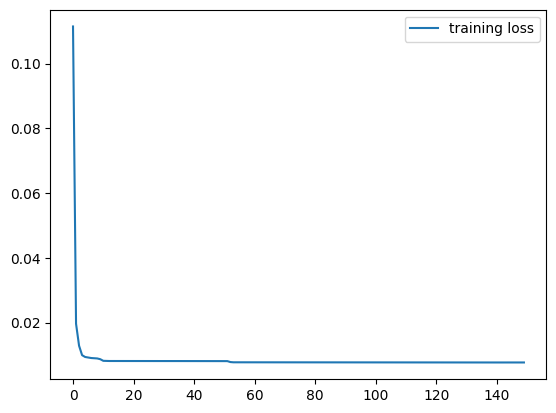

In [ ]:
plt.plot(history.history['loss'], label='training loss')
#plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
tf.keras.utils.set_random_seed(50)
predictions  = auto_model.predict(x_test_scaled)
recon_error = dict()
for i in range(len(x_test_scaled)):
  recon_error[i] = np.mean(np.power(x_test_scaled[i] - predictions[i], 2))
#get mean squared error
mean_squared_error = metrics.mean_squared_error(predictions, x_test_scaled)
print(mean_squared_error)
df_error = pd.DataFrame({'reconstruction_error': recon_error, 'Label': target_test}, index=test.index)

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
0.051849873718082966


In [ ]:
outliers = df_error.index[df_error.reconstruction_error > mean_squared_error].tolist()
#reconstructionerrors = df_error.reconstruction_error.tolist()
print(len(outliers))
print(outliers)

13836
[2, 3, 5, 7, 8, 9, 10, 14, 15, 16, 17, 18, 22, 23, 26, 27, 28, 29, 32, 33, 36, 37, 38, 39, 41, 42, 43, 45, 47, 49, 50, 51, 54, 55, 57, 58, 59, 60, 61, 62, 63, 65, 69, 72, 73, 75, 76, 77, 78, 79, 82, 83, 84, 85, 88, 89, 90, 91, 94, 96, 97, 101, 106, 107, 109, 110, 112, 113, 114, 116, 117, 119, 120, 121, 124, 125, 126, 128, 129, 130, 131, 133, 134, 135, 137, 139, 140, 141, 145, 148, 149, 152, 154, 156, 164, 167, 168, 170, 171, 175, 178, 180, 181, 182, 183, 184, 185, 188, 190, 191, 194, 195, 196, 197, 199, 201, 203, 204, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 228, 229, 230, 232, 233, 235, 237, 241, 245, 246, 249, 252, 253, 257, 258, 259, 260, 261, 262, 266, 267, 268, 269, 271, 275, 277, 280, 281, 282, 285, 286, 288, 290, 293, 294, 295, 297, 299, 302, 303, 304, 305, 307, 311, 312, 313, 314, 316, 317, 319, 320, 322, 324, 325, 326, 327, 333, 335, 336, 337, 342, 343, 344, 345, 348, 349, 352, 353, 354, 355, 356, 357, 358, 360, 361, 363, 364, 

In [ ]:
#pred_data = x_test_scaled[126]
#print(pred_data)
#pred_data = x_test_scaled
#pred_data[outliers] = 0
#print(pred[1])
#accuracy = accuracy_score(test[126], pred_data)
#print(accuracy)
num = 0
for i in range(len(y_test)):
  y_test[i] = 1

for i in range(len(outliers)):
  y_test[outliers[i]] = 0

accuracy = accuracy_score(target_test, y_test)
print(accuracy)
precision = precision_score(target_test, y_test)
print(precision)
recall = recall_score(target_test, y_test)
print(recall)

0.24880234208658622
0.08520900321543408
0.0764081968901246


In [ ]:

from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.DataTable(
    newframe, include_index=True, max_rows=10, max_columns=127)

AttributeError: 'numpy.ndarray' object has no attribute '_mgr'

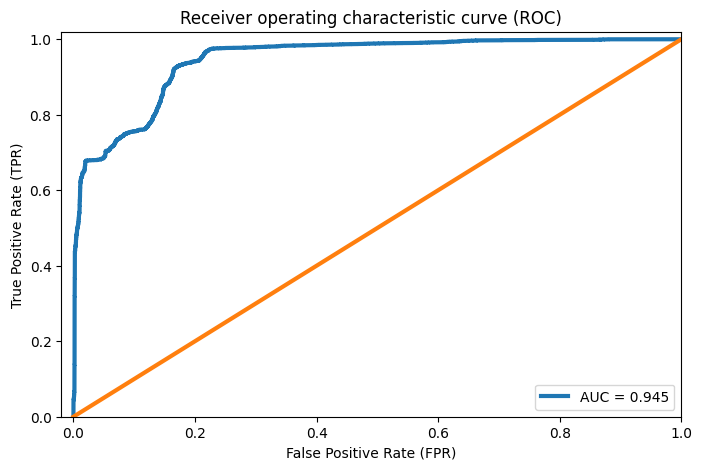

In [ ]:
tpr, fpr, thresholds = roc_curve(df_error.Label, df_error.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (8, 5))
plt.plot(fpr, tpr, linewidth = 3, label = 'AUC = %0.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linewidth = 3)
plt.xlim(left = -0.02, right = 1)
plt.ylim(bottom = 0, top = 1.02)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic curve (ROC)')
plt.legend()
plt.show()

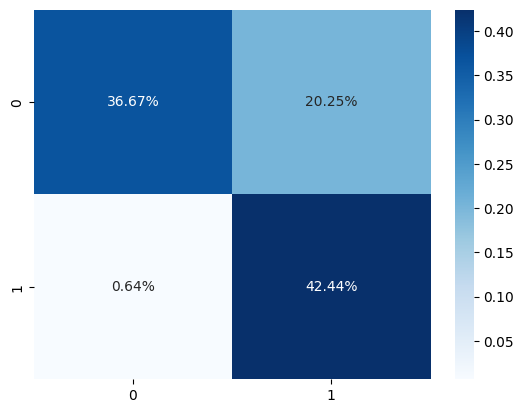

In [ ]:
confusion_matrix = metrics.confusion_matrix(target_test, y_test)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
#cm_display.plot()
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()